<a href="https://colab.research.google.com/github/Nachos-mic/Rotten_Review_Model/blob/main/EDT_Rotten_Review_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Review Analysis Pipeline
IMDB Sentiment Model + Rotten Tomatoes Fake/Biased Review Detection


#MODEL 1 - Przygotowanie danych i trening

In [55]:
!pip install contractions -qq
!pip install vaderSentiment

In [56]:
# Ustawianie środowiska
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import timedelta


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import warnings

import contractions
from bs4 import BeautifulSoup
import kagglehub
import os
import glob

# Instalowanie pakietów NLTK
for resource in ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [57]:
# Funkcje do czyszczenia datasetu
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def expand_contractions(text):
    return contractions.fix(text)

def to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

def clean_text(text):
    # Obsługa NaN, None i pustych wartości
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

Przygotowanie datasetu IMDB

In [58]:
print("\nŁadowanie datasetu IMDB...")


dataset_path_imdb = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path_imdb = os.path.join(dataset_path_imdb, "IMDB Dataset.csv")
df_imdb = pd.read_csv(csv_path_imdb)

print(f"Załadowano recenzje IMDB reviews")
print(f"Podział sentymentu:\n{df_imdb['sentiment'].value_counts()}")

# Przygotowanie datasetu
print("\nCzyszczenie datasetu...")
df_imdb['review_cleaned'] = df_imdb['review'].apply(clean_text)
df_imdb['sentiment_label'] = df_imdb['sentiment'].map({'positive': 1, 'negative': -1})

df_imdb = df_imdb[df_imdb['review_cleaned'].str.strip() != ''].copy()

df_imdb_final = df_imdb[['review_cleaned', 'sentiment_label']].copy()
df_imdb_final = df_imdb_final.rename(columns={'review_cleaned': 'text', 'sentiment_label': 'label'})
df_imdb_final['source'] = 'IMDB'

print(f"\nPrzygotowano dane: {df_imdb_final.shape}")
print(f"Podział etykiet:")
print(df_imdb_final['label'].value_counts())
print(f"Pozytywne (1): {(df_imdb_final['label'] == 1).sum()} ({(df_imdb_final['label'] == 1).sum()/len(df_imdb_final)*100:.1f}%)")
print(f"Negatywne (-1): {(df_imdb_final['label'] == -1).sum()} ({(df_imdb_final['label'] == -1).sum()/len(df_imdb_final)*100:.1f}%)")


Ładowanie datasetu IMDB...
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Załadowano recenzje IMDB reviews
Podział sentymentu:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Czyszczenie datasetu...

Przygotowano dane: (50000, 3)
Podział etykiet:
label
 1    25000
-1    25000
Name: count, dtype: int64
Pozytywne (1): 25000 (50.0%)
Negatywne (-1): 25000 (50.0%)


Przygotowanie datasetu Rotten Tomatoes (Clapper Rotten Tomatoes)

In [59]:
# Ładowanie datasetu Rotten Tomatoes
print("Ładowanie datasetu Clapper Rotten Tomatoes")

dataset_path_clapper = kagglehub.dataset_download(
    "andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews"
)

csv_files = glob.glob(os.path.join(dataset_path_clapper, "*.csv"))
print(f"Znaleziono pliki: {[os.path.basename(f) for f in csv_files]}")

reviews_file = None
for f in csv_files:
    fname = os.path.basename(f).lower()
    if 'review' in fname and 'movie' not in fname:
        reviews_file = f
        break
    elif 'movie_review' in fname:
        reviews_file = f
        break

if not reviews_file and csv_files:
    for f in csv_files:
        if 'review' in os.path.basename(f).lower():
            reviews_file = f
            break
    if not reviews_file:
        reviews_file = csv_files[0]

df_clapper = pd.read_csv(reviews_file)

# Filtracja top-krytyków
top_critic_col = None
for col in df_clapper.columns:
    col_lower = col.lower().replace('_', '').replace(' ', '')
    if 'topcritic' in col_lower or 'istopdcritic' in col_lower:
        top_critic_col = col
        break

if top_critic_col:
    print(f"\nFiltracja top-krytyków (przed: {len(df_clapper)})")
    df_clapper = df_clapper[
        (df_clapper[top_critic_col] == True) |
        (df_clapper[top_critic_col] == 1) |
        (df_clapper[top_critic_col] == 'True') |
        (df_clapper[top_critic_col] == 'true')
    ].copy()
    print(f"   Po filtracji: {len(df_clapper)}")
else:
    print("\nKolumna top-krytyków nie znaleziona - używam wszystkich recenzji")

# Detekcja kolumn
text_col = None
label_col = None
score_sentiment_col = None

for col in df_clapper.columns:
    col_lower = col.lower().replace('_', '').replace(' ', '')

    if any(x in col_lower for x in ['reviewtext', 'text', 'content']):
        if text_col is None:
            text_col = col

    if any(x in col_lower for x in ['reviewstate', 'state', 'type']):
        if 'score' not in col_lower:
            label_col = col

    if 'scoresentiment' in col_lower or ('score' in col_lower and 'sentiment' in col_lower):
        score_sentiment_col = col

if score_sentiment_col:
    df_clapper = df_clapper.drop(columns=[score_sentiment_col])

if text_col is None or label_col is None:
    raise ValueError("Nie znaleziono wymaganych kolumn text/label")

# Czyszczenie tekstu
print(f"\nCzyszczenie tekstu (przed: {len(df_clapper)})")
df_clapper = df_clapper[df_clapper[text_col].notna()].copy()
df_clapper['text_cleaned'] = df_clapper[text_col].apply(clean_text)
df_clapper = df_clapper[df_clapper['text_cleaned'].str.strip() != ''].copy()
print(f"   Po czyszczeniu: {len(df_clapper)}")

# Mapowanie etykiet
def map_rt_sentiment(val):
    if pd.isna(val):
        return None
    val_str = str(val).lower().strip()
    if val_str in ['fresh', 'positive', '1', 'pos']:
        return 1
    elif val_str in ['rotten', 'negative', '0', 'neg']:
        return -1
    else:
        return None

df_clapper['sentiment_label'] = df_clapper[label_col].apply(map_rt_sentiment)
df_clapper = df_clapper.dropna(subset=['sentiment_label']).copy()

# Finalne przygotowanie
df_clapper_final = df_clapper[['text_cleaned', 'sentiment_label']].copy()
df_clapper_final = df_clapper_final.rename(columns={'text_cleaned': 'text', 'sentiment_label': 'label'})
df_clapper_final['label'] = df_clapper_final['label'].astype(int)
df_clapper_final['source'] = 'Clapper_RT'

print(f"\nClapper RT przygotowany: {df_clapper_final.shape}")
print(f"   Podział etykiet: {df_clapper_final['label'].value_counts().to_dict()}")

Ładowanie datasetu Clapper Rotten Tomatoes
Using Colab cache for faster access to the 'clapper-massive-rotten-tomatoes-movies-and-reviews' dataset.
Znaleziono pliki: ['rotten_tomatoes_movies.csv', 'rotten_tomatoes_movie_reviews.csv']

Filtracja top-krytyków (przed: 1444963)
   Po filtracji: 436807

Czyszczenie tekstu (przed: 436807)
   Po czyszczeniu: 426268

Clapper RT przygotowany: (426268, 3)
   Podział etykiet: {1: 269728, -1: 156540}


Merge dwóch datasetów

In [60]:
#Łączenie datasetu IMDB i Rotten
print("Łączenie datasetu")

# Połącz oba datasety
df_combined = pd.concat([df_imdb_final, df_clapper_final], ignore_index=True)

# Usuń duplikaty tekstowe
print(f"\nUsuwanie duplikatów...")
original_size = len(df_combined)
df_combined = df_combined.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_size - len(df_combined)
print(f"Usunięto {duplicates_removed} duplikatów ({duplicates_removed/original_size*100:.1f}%)")

# Losowe przemieszanie
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nPołączony dataset: {df_combined.shape}")
print("\nPodział datasetu:")
print(f"  IMDB: {(df_combined['source'] == 'IMDB').sum()}")
print(f"  Clapper RT: {(df_combined['source'] == 'Clapper_RT').sum()}")


Łączenie datasetu

Usuwanie duplikatów...
Usunięto 5391 duplikatów (1.1%)

Połączony dataset: (470877, 3)

Podział datasetu:
  IMDB: 49574
  Clapper RT: 421303


Trening modelu na łączonym datasecie i jego ewaluacja

Trening modelu

Wektoryzacja tekstu...

Statystyki podziału na zbiory:
   Treningowy: 376701
   Testowy: 94176
   Podział etykiet: {1: 233106, -1: 143595}

Ewaluacja modelu...
   Train Accuracy: 0.8174
   Test Accuracy:  0.8016
               precision    recall  f1-score   support

Negative (-1)       0.77      0.68      0.72     35899
 Positive (1)       0.82      0.87      0.85     58277

     accuracy                           0.80     94176
    macro avg       0.79      0.78      0.78     94176
 weighted avg       0.80      0.80      0.80     94176



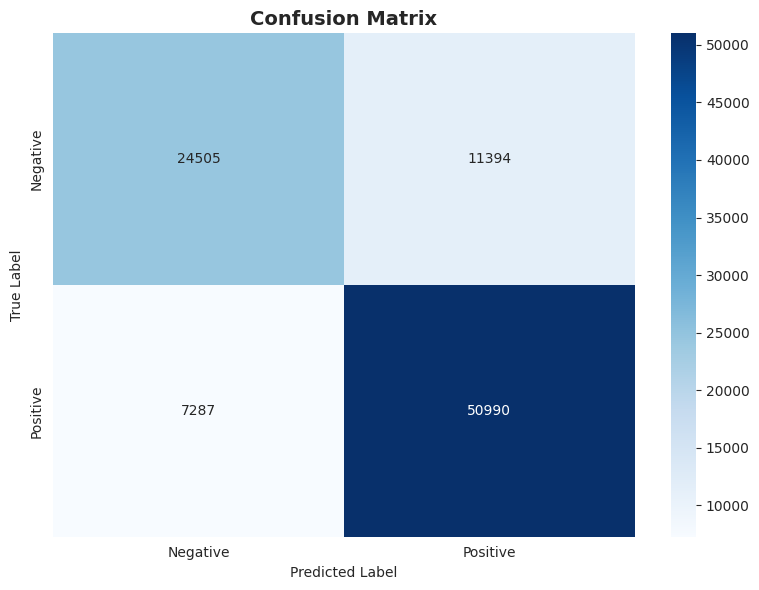

In [61]:
#Trening modelu sentymentu
print("Trening modelu")

print("\nWektoryzacja tekstu...")
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
X = vectorizer.fit_transform(df_combined['text'])
y = df_combined['label']

# Podział na zbiory train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nStatystyki podziału na zbiory:")
print(f"   Treningowy: {X_train.shape[0]}")
print(f"   Testowy: {X_test.shape[0]}")
print(f"   Podział etykiet: {pd.Series(y_train).value_counts().to_dict()}")

# Trenowanie
model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
model.fit(X_train, y_train)

#zapisanie danych dla gui
sentiment_model = model  # Logistic Regression
sentiment_vectorizer = vectorizer  # CountVectorizer

# Ewaluacja
print("\nEwaluacja modelu...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")


print(classification_report(y_test, y_pred_test,
                          target_names=['Negative (-1)', 'Positive (1)']))

#Macierz pomyłek
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


Funkcja do wywołania predykcji opartej na powyższym modelu

In [62]:
def predict_sentiment(review_text):
    """Funkcja do predykcji sentymentu (pozytywne 1, negatywne -1)"""
    cleaned = clean_text(review_text)
    vector = vectorizer.transform([cleaned])
    return model.predict(vector)[0]

# MODEL 2 - Przygotowanie danych z osobnego zbioru danych

EDA & PREPROCESSING

In [63]:
print("Ładowanie datasetu Rotten Tomatoes")

dataset_path_rt = kagglehub.dataset_download(
    "stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset"
)

movies_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_movies.csv")
reviews_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_critic_reviews.csv")

movies_df = pd.read_csv(movies_csv)
reviews_df = pd.read_csv(reviews_csv)

print(f"\nFilmy: {movies_df.shape}")
print(f"\nRecenzje: {reviews_df.shape}")

Ładowanie datasetu Rotten Tomatoes
Using Colab cache for faster access to the 'rotten-tomatoes-movies-and-critic-reviews-dataset' dataset.

Filmy: (17712, 22)

Recenzje: (1130017, 8)


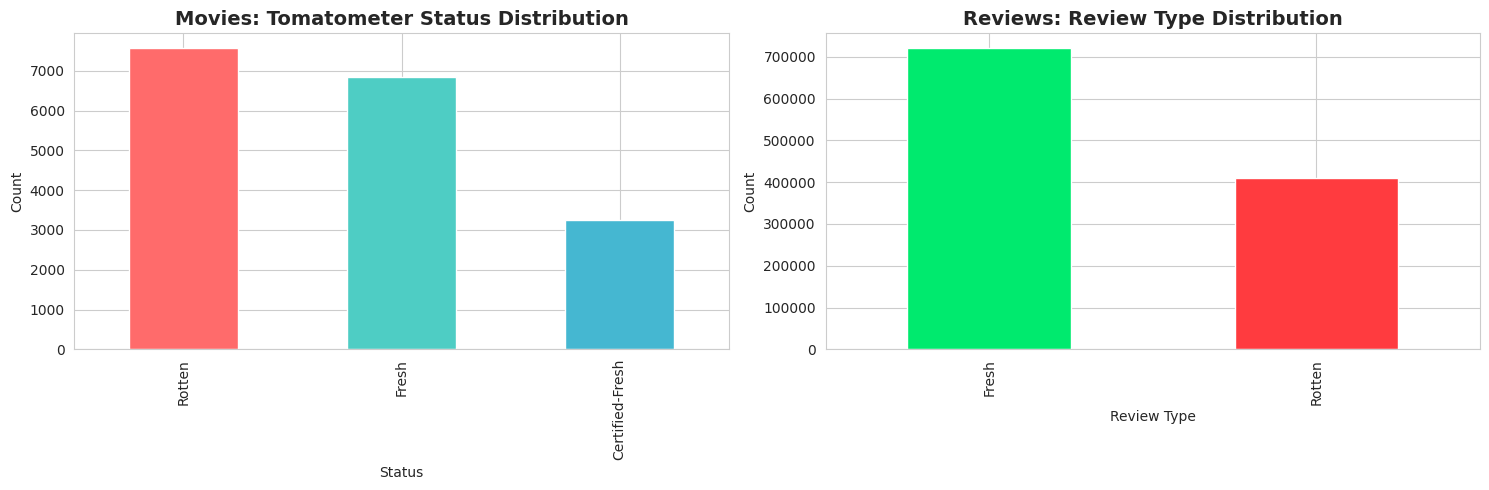

In [64]:
# Analiza rozkładu sentymentu
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if 'tomatometer_status' in movies_df.columns:
    movies_df['tomatometer_status'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_title('Movies: Tomatometer Status Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Status')
    axes[0].set_ylabel('Count')

if 'review_type' in reviews_df.columns:
    reviews_df['review_type'].value_counts().plot(kind='bar', ax=axes[1], color=['#00EA6E', '#FF3B3F'])
    axes[1].set_title('Reviews: Review Type Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Review Type')
    axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [65]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4', '6.5/10', '3/10', '1.5/5', '4/10', '7/10', '6/10', 'B+',
       '5/5', 'A-', '4.5/5', '5.78/10', '3.5/4', 'A', '9/10', '8.5/10',
       '4/4', '83/100', '8/10', '92/100', '82/100', '84/100', '10/10',
       'D-', 'F', '0.5/4', 'D', '5/10', '2/10', '2/6', '0.5/5', '0/4',
       '0/5', '76/100', '87/100', '74/100', '86/100', '81/100', '56/100',
       '78/100', '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4', '2.4/5',
       '8.6/10', '79/100', '68/100', '80/100', '90/100', '66/100',
       '91/100', '0.3/5', '9.2/10', '2.7/5', '57/100', '4/6', '3/6',
       '73/100', '42/100', '65/100', '7.5/10', '4.5/10', '5/6', '1/6',
       '70/100', '3.5/10', '71/100', '0.1/5', '3.25/10', '89/100',
       '40/100', '64/100', '62/100', '1/10', '3.75/5', '37/100', '49/100',
       '60/100', '3.3/5', '77/100', '5.25/10', '1.4/4', '75/100', '1.5/6

In [66]:
# EDA 1: Początkowa eksploracja danych
print("Eksploracja datasetów")

print("\nRecenzje:")
print(f"  Ilość recenzji: {len(reviews_df)}")
print(f"  Brakujące dane:\n{reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0]}")
print(f"\n  Podział recenzentów:")
print(reviews_df['top_critic'].value_counts(dropna=False))

print("\nFilmy:")
print(f"  Ilość filmów: {len(movies_df)}")
#Konwersja  danych z kolumny 'original_release_date' do typu datetime
movies_df['original_release_date'] = pd.to_datetime(movies_df['original_release_date'], errors='coerce')
print(f"  Zakres dat: {movies_df['original_release_date'].min()} - {movies_df['original_release_date'].max()}")

Eksploracja datasetów

Recenzje:
  Ilość recenzji: 1130017
  Brakujące dane:
critic_name        18529
review_score      305936
review_content     65806
dtype: int64

  Podział recenzentów:
top_critic
False    841481
True     288536
Name: count, dtype: int64

Filmy:
  Ilość filmów: 17712
  Zakres dat: 1914-06-01 00:00:00 - 2020-09-30 00:00:00


In [67]:
#Preprocessing danych
print("Filtrowanie top-krytyków")

original_count = len(reviews_df)
reviews_df = reviews_df[reviews_df['top_critic'] == True].copy()
print(f"Po filtracji zostało {len(reviews_df)/original_count*100:.1f}% danych")

Filtrowanie top-krytyków
Po filtracji zostało 25.5% danych


In [68]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '3/5', '2/4', '2/5', '3/4', 'C-', '2.5/4', 'C+', 'D+',
       '1/5', 'C', '4/5', 'A-', '4.5/5', '3.5/4', 'A', '1.5/4', '4/4',
       'B', '5/5', '1.5/5', '1/4', 'D', 'F', '2/6', 'B-', '0/4', 'B+',
       'D-', '2.5/5', '0.5/4', '0/5', '2.4/5', '4/6', '3/6', '5/10',
       '5/6', '1/6', '5.5/10', '7/10', '8/10', '6/10', '3/10', '8.5/10',
       '5.9/10', '4.6/10', '3.4/10', '10/10', '0.5/5', '35/100', '1/3',
       '42/100', '9/10', '55/100', '80/100', '78/100', '94/100', '5/100',
       '75/100', '50/100', '30/100', '62/100', '52/100', '3', '2/2',
       '4/10', '3.5/6', '7.5/10', '6.4/10', '4.5/10', '45/100', '70/100',
       '2.5/10', '68/100', '15/100', '0', '0.5/10', '2', '0/6', '0/10',
       '1/10', '8.3/10', '8.1/10', '3.5/10', '1.2/10', '5.2/10', '6.5/10',
       '6.2/10', '47/100', '4.2/10', '9.1/10', '20/100', '7.2/10',
       '40/100', '85/100', '5', '10/100', '90/100', '4.8/10', '41/100',
       '6.8/10', '6.6/10', '5.3/10', '3/3', '8.6/10', '6.3/10', '8.7/1

Łączenie zbioru z recenzjami i z filmami

In [69]:
#Łączenie datasetów
print("Łączenie datasetów (Recenzje krytyków + filmy)")

movie_cols = ['rotten_tomatoes_link', 'original_release_date', 'tomatometer_rating',
              'tomatometer_status', 'audience_rating', 'audience_status', 'movie_title']
movies_subset = movies_df[movie_cols].copy()

df = reviews_df.merge(movies_subset, on='rotten_tomatoes_link', how='left')
print(f"Ukończono łączenie datasetów: {df.shape}")
# print(f"{(1 - df['original_release_date'].isna().sum()/len(df))*100:.1f}%")

Łączenie datasetów (Recenzje krytyków + filmy)
Ukończono łączenie datasetów: (288536, 14)


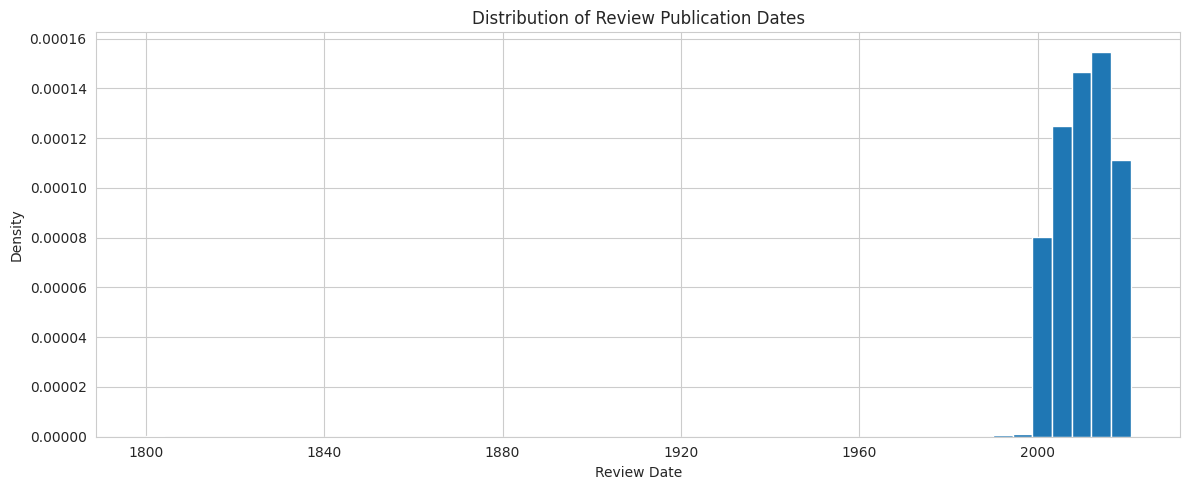

In [70]:
df['review_date'] = pd.to_datetime(df['review_date'])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.hist(
    df['review_date'],
    bins=50,
    density=True
)

plt.xlabel("Review Date")
plt.ylabel("Density")
plt.title("Distribution of Review Publication Dates")

plt.tight_layout()
plt.show()


In [71]:
# Analiza jakości tekstów recenzji
print("\nAnaliza tekstu")

sample_reviews = df['review_content'].dropna().head(10)
print(f"   Przykład (pierwsze 200 znaków): {sample_reviews.iloc[0][:200]}")

html_pattern = re.compile('<.*?>')
has_html = df['review_content'].str.contains(html_pattern, na=False).sum()
print(f"   Recenzje z HTML: {has_html}")

url_pattern = re.compile(r'https?://\\S+|www\\.\\S+')
has_urls = df['review_content'].str.contains(url_pattern, na=False).sum()
print(f"   Recenzje z URL: {has_urls}")

df['review_length_raw'] = df['review_content'].str.len()
print(f"\n   Statystyki długości:")
print(f"      Średnia: {df['review_length_raw'].mean():.0f}")
print(f"      Mediana: {df['review_length_raw'].median():.0f}")
print(f"      Min-Max: {df['review_length_raw'].min():.0f} - {df['review_length_raw'].max():.0f}")


Analiza tekstu
   Przykład (pierwsze 200 znaków): What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again.
   Recenzje z HTML: 0
   Recenzje z URL: 0

   Statystyki długości:
      Średnia: 129
      Mediana: 128
      Min-Max: 4 - 257


In [72]:
#Czyszczenie tekstu
print("Czyszczenie tekstu")

CHAT_WORDS = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

def remove_urls(text):
    if not isinstance(text, str):
        return ''
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    if not isinstance(text, str):
        return ''
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emotikony
        u"\U0001F300-\U0001F5FF"  # symbole i piktogramy
        u"\U0001F680-\U0001F6FF"  # transport i symbole map
        u"\U0001F1E0-\U0001F1FF"  # flagi (iOS)
        u"\U00002500-\U00002BEF"  # chińskie znaki/symbole
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"
        u"\U0001F926-\U0001F937"  # dodatkowe twarze i gesty
        u"\U00010000-\U0010ffff"  # dodatkowe symbole
        u"\U0001F900-\U0001F9FF"  # symbole emotikony (2017+)
        u"\U0001FA00-\U0001FA6F"  # symbole rozszerzone-A
        u"\U0001FA70-\U0001FAFF"  # symbole rozszerzone-B
        u"\u2640-\u2642"           # symbole płci
        u"\u2600-\u2B55"           # różne symbole
        u"\u200d"                  # zero width joiner
        u"\ufe0f"                  # variation selector
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)


def expand_chat_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    expanded = [CHAT_WORDS.get(word.upper(), word) for word in words]
    return ' '.join(expanded)

def remove_punctuation(text):
    if not isinstance(text, str):
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

def clean_text_rt(text):
    if not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = expand_chat_words(text)
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)

    return text

print("Czyszczenie tekstu w recenzjach...")
df['text_cleaned'] = df['review_content'].apply(clean_text_rt)

print(f"Wyczyszczono {len(df)} recenzji")

Czyszczenie tekstu
Czyszczenie tekstu w recenzjach...
Wyczyszczono 288536 recenzji


In [73]:
# EDA 3: Analiza po czyszczeniu
print("Analiza po czyszczeniu")

df['text_length_cleaned'] = df['text_cleaned'].str.len()
print("Analiza długości tekstów:")
print(df['text_length_cleaned'].describe())

print("\nPrzykładowa recenzja:")
print(df['text_cleaned'].iloc[0][:200])

Analiza po czyszczeniu
Analiza długości tekstów:
count    288536.000000
mean        121.980980
std          57.411691
min           0.000000
25%          80.000000
50%         122.000000
75%         164.000000
max         275.000000
Name: text_length_cleaned, dtype: float64

Przykładowa recenzja:
whats really lacking in the lightning thief is a genuine sense of wonder the same thing that brings viewers back to hogwarts over and over again


In [74]:
#Tokenizacja i lematyzacja
print("\nTokenizacja i lematyzacja")

def get_wordnet_pos(treebank_tag):
    tag_dict = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0], wordnet.NOUN)

def tokenize_and_lemmatize(text, remove_stopwords=True, min_word_length=2):
    if not isinstance(text, str) or not text.strip():
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and len(word) >= min_word_length]

    if remove_stopwords:
        stop_words_set = set(stopwords.words('english'))
        custom_stopwords = {'film', 'movie', 'movies', 'films', 'scene', 'scenes'}
        stop_words_set.update(custom_stopwords)
        tokens = [word for word in tokens if word not in stop_words_set]

    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
                  for word, pos in pos_tags]

    return lemmatized

df['tokens'] = df['text_cleaned'].apply(tokenize_and_lemmatize)
df['token_count'] = df['tokens'].apply(len)
df['tokens_text'] = df['tokens'].apply(lambda x: ' '.join(x))

print(f"   Średnia tokenów: {df['token_count'].mean():.1f}")
print(f"   Mediana: {df['token_count'].median():.0f}")


Tokenizacja i lematyzacja
   Średnia tokenów: 11.5
   Mediana: 11


In [75]:
# Przetwarzanie dat
print("\nPrzetwarzanie dat")

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['original_release_date'] = pd.to_datetime(df['original_release_date'], errors='coerce')

df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['release_year'] = df['original_release_date'].dt.year

df['days_since_release'] = (df['review_date'] - df['original_release_date']).dt.days

print(f"   Recenzje z datami: {df['days_since_release'].notna().sum()}")
print(f"   Zakres: {df['review_date'].min()} - {df['review_date'].max()}")



Przetwarzanie dat
   Recenzje z datami: 283202
   Zakres: 1800-01-01 00:00:00 - 2020-10-27 00:00:00


In [76]:
# Analiza czasowa recenzji
print("\nAnaliza czasowa recenzji")

early_reviews = (df['days_since_release'] < 7).sum()
print(f"   Wczesne recenzje (< 7 dni): {early_reviews} ({early_reviews/len(df)*100:.1f}%)")

print(f"\n   Dni od premiery:")
print(f"      Średnia: {df['days_since_release'].mean():.0f}")
print(f"      Mediana: {df['days_since_release'].median():.0f}")
print(f"      Min-Max: {df['days_since_release'].min():.0f} - {df['days_since_release'].max():.0f}")



Analiza czasowa recenzji
   Wczesne recenzje (< 7 dni): 178789 (62.0%)

   Dni od premiery:
      Średnia: 1076
      Mediana: 0
      Min-Max: -77261 - 38854


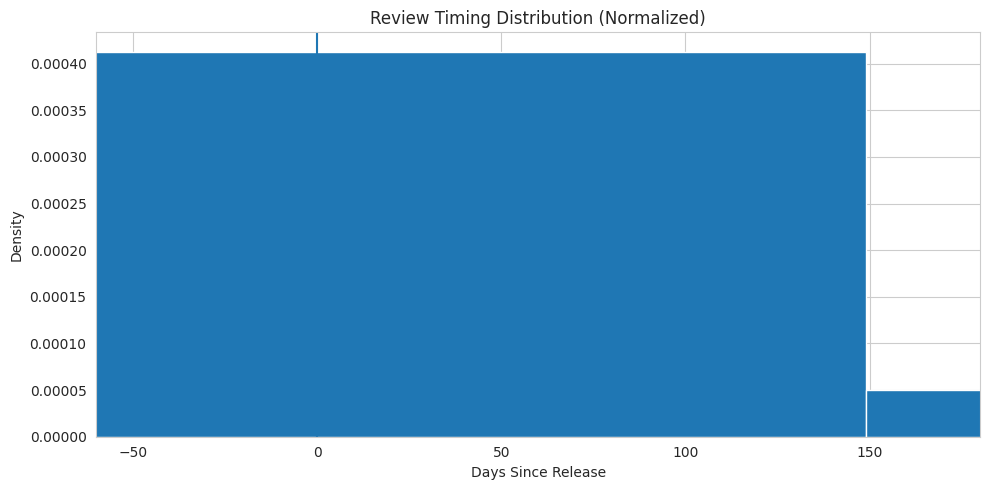

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

df['days_since_release'].plot.hist(
    bins=60,
    density=True
)

plt.axvline(0)
plt.xlabel("Days Since Release")
plt.ylabel("Density")
plt.title("Review Timing Distribution (Normalized)")

plt.xlim(-60, 180)
plt.tight_layout()
plt.show()


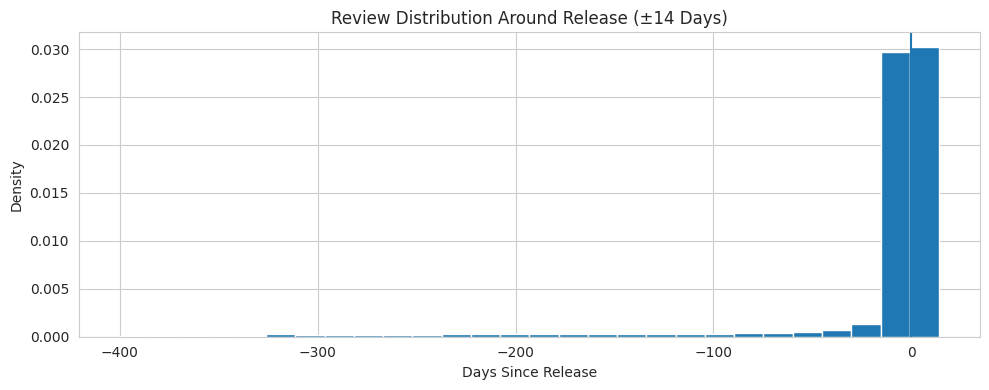

In [78]:
plt.figure(figsize=(10, 4))

df[
    (df['days_since_release'] >= -400) &
    (df['days_since_release'] <= 14)
]['days_since_release'].plot.hist(
    bins=28,
    density=True
)

plt.axvline(0)
plt.xlabel("Days Since Release")
plt.ylabel("Density")
plt.title("Review Distribution Around Release (±14 Days)")

plt.tight_layout()
plt.show()


In [79]:
df.sort_values('days_since_release').head(5)[
    ['movie_title', 'days_since_release', 'review_date', 'original_release_date']
]


,movie_title,days_since_release,review_date,original_release_date
102388,Gunless,-77261.0,1800-01-01,2011-07-15
48037,Black Death,-77135.0,1800-01-01,2011-03-11
105544,Heartless,-77023.0,1800-01-01,2010-11-19
276590,Wah Do Dem,-76869.0,1800-01-01,2010-06-18
276591,Wah Do Dem,-76869.0,1800-01-01,2010-06-18


In [80]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['original_release_date'] = pd.to_datetime(df['original_release_date'])

# znajdź najnowszy film (max release_date)
latest_release_date = df['original_release_date'].max()

# wszystkie recenzje tego filmu
latest_movie_reviews = df[df['original_release_date'] == latest_release_date]

# najstarsza recenzja dla tego filmu
oldest_review_latest_movie = latest_movie_reviews.sort_values('review_date').head(1)

oldest_review_latest_movie[
    ['movie_title', 'original_release_date', 'review_date', 'days_since_release']
]


,movie_title,original_release_date,review_date,days_since_release
17133,Billy the Kid,2020-09-30,2007-12-03,-4685.0


In [81]:
# Feature engineering
print("\nFeature engineering")

df['review_type_encoded'] = df['review_type'].map({'Fresh': 1, 'Rotten': 0})

df['word_count'] = df['text_cleaned'].str.split().str.len()
df['sentence_count'] = df['text_cleaned'].str.count(r'[.!?]') + 1
df['avg_word_length'] = df['text_length_cleaned'] / df['word_count'].replace(0, 1)
df['unique_word_count'] = df['tokens'].apply(lambda x: len(set(x)))
df['lexical_diversity'] = df['unique_word_count'] / df['token_count'].replace(0, 1)

df['is_early_review'] = df['days_since_release'] < 7

print(f"   Utworzono cechy: tekstowe (7), czasowe (5), kategoryczne (1)")


Feature engineering
   Utworzono cechy: tekstowe (7), czasowe (5), kategoryczne (1)


Użycie sentymentu z predykcji modelu nr.1

In [82]:
#Dodanie sentymentu z modelu nr.1
print("\nPredykcja sentymentu")

df['predicted_sentiment'] = df['text_cleaned'].apply(predict_sentiment)

sentiment_dist = df['predicted_sentiment'].value_counts()
print(f"   Pozytywny (1): {sentiment_dist.get(1, 0)} ({sentiment_dist.get(1, 0)/len(df)*100:.1f}%)")
print(f"   Negatywny (-1): {sentiment_dist.get(-1, 0)} ({sentiment_dist.get(-1, 0)/len(df)*100:.1f}%)")



Predykcja sentymentu
   Pozytywny (1): 191881 (66.5%)
   Negatywny (-1): 96655 (33.5%)


Predykcja jest bardzo zbliżona procentowo do podziału z oryginalnego datasetu (64% Fresh, 36% Rotten w zbiorze)

In [83]:
# EDA 5: Walidacja modelu sentymentu
print("\nWalidacja modelu sentymentu")

crosstab = pd.crosstab(
    df['review_type'],
    df['predicted_sentiment'],
    normalize='index'
) * 100

print(f"\n   Predykcja sentymentu wg typu recenzji (%):")
print(crosstab.round(1).to_string(index=True).replace('\n', '\n   '))

df['sentiment_matches'] = (
    ((df['review_type'] == 'Fresh') & (df['predicted_sentiment'] == 1)) |
    ((df['review_type'] == 'Rotten') & (df['predicted_sentiment'] == -1))
)
agreement = df['sentiment_matches'].mean() * 100
print(f"\n   Zgodność: {agreement:.1f}%")



Walidacja modelu sentymentu

   Predykcja sentymentu wg typu recenzji (%):
predicted_sentiment    -1     1
   review_type                    
   Fresh                12.3  87.7
   Rotten               64.0  36.0

   Zgodność: 78.0%



Generowanie chmur słów


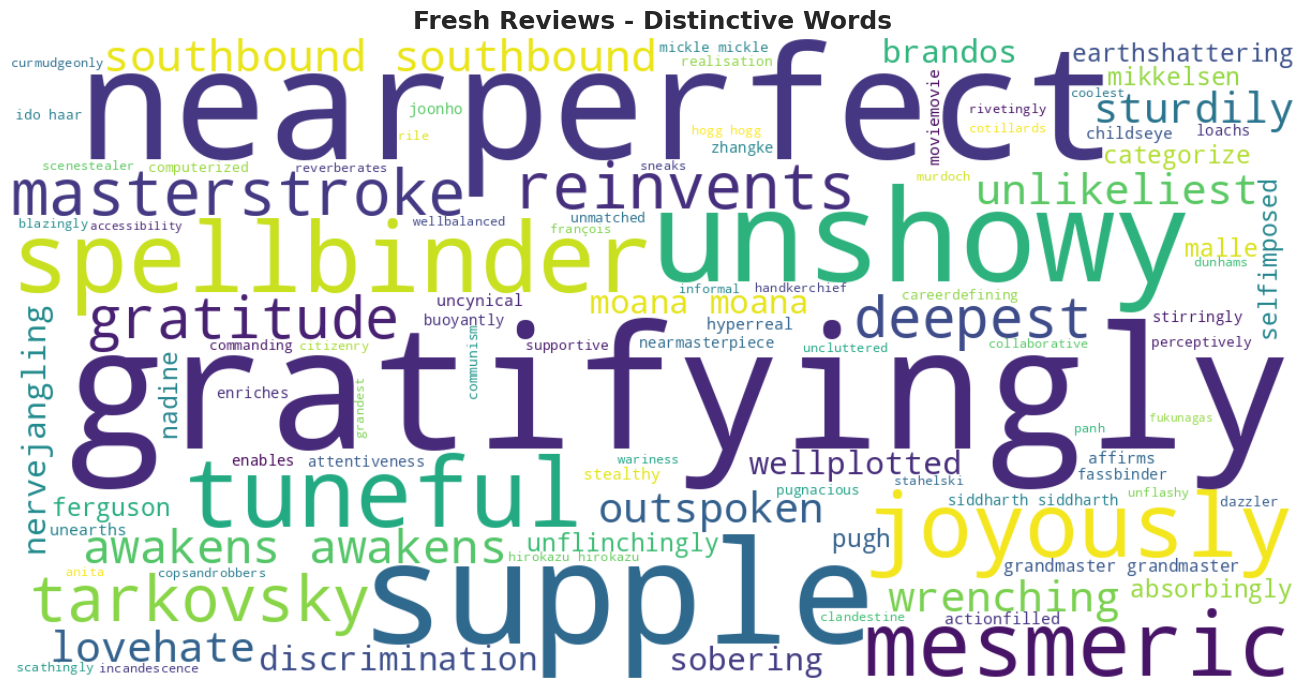

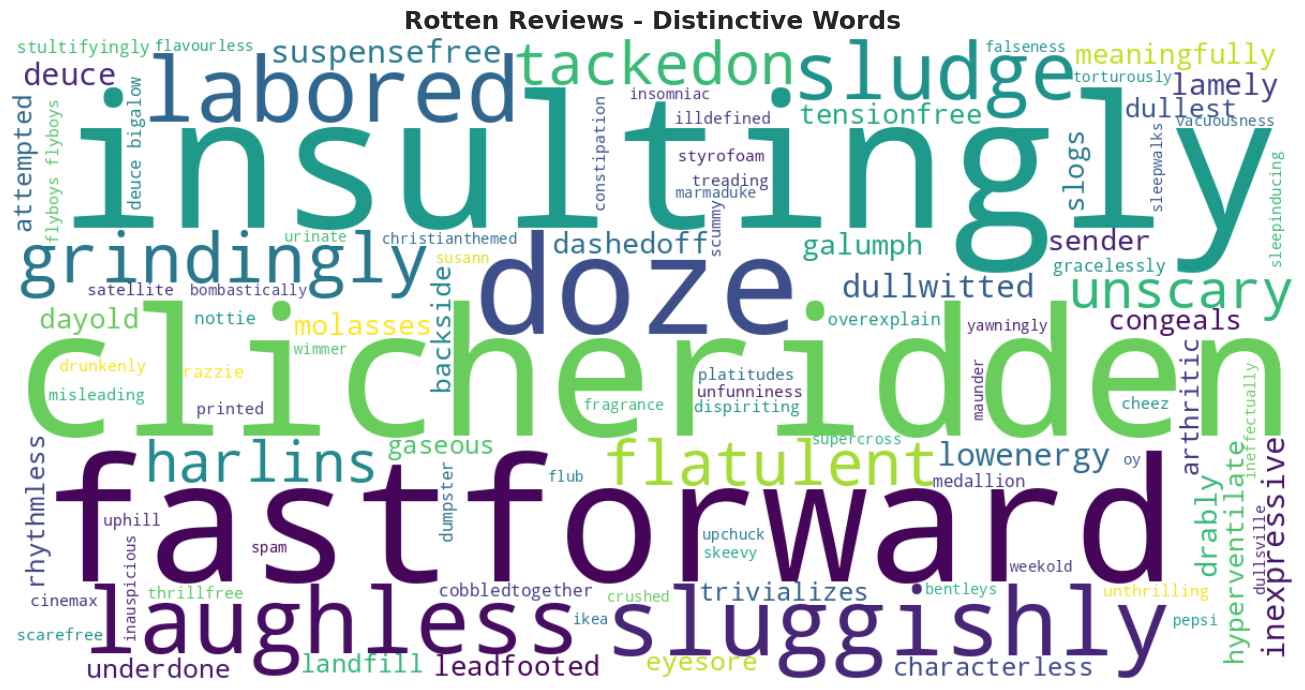

In [84]:
# Generowanie chmur słów
print("\nGenerowanie chmur słów")

def generate_wordcloud(tokens_series, title, exclude_tokens=None):
    all_tokens = [token for tokens in tokens_series for token in tokens]
    if not all_tokens:
        return

    if exclude_tokens:
        all_tokens = [token for token in all_tokens if token not in exclude_tokens]

    if not all_tokens:
        return

    text = ' '.join(all_tokens)
    wordcloud = WordCloud(
        width=1200, height=600,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

fresh_reviews = df[df['review_type'] == 'Fresh']
rotten_reviews = df[df['review_type'] == 'Rotten']

fresh_tokens = [token for tokens in fresh_reviews['tokens'] for token in tokens]
rotten_tokens = [token for tokens in rotten_reviews['tokens'] for token in tokens]

fresh_freq = pd.Series(fresh_tokens).value_counts()
rotten_freq = pd.Series(rotten_tokens).value_counts()

common_words = set(fresh_freq.index) & set(rotten_freq.index)

generate_wordcloud(fresh_reviews['tokens'], 'Fresh Reviews - Distinctive Words', exclude_tokens=common_words)
generate_wordcloud(rotten_reviews['tokens'], 'Rotten Reviews - Distinctive Words', exclude_tokens=common_words)

In [85]:
mismatched_df = df[~df['sentiment_matches']]

print(f"Liczba niezgodnych recenzji: {len(mismatched_df)} ({len(mismatched_df)/len(df)*100:.1f}%)")

mismatched_df[['review_type', 'predicted_sentiment', 'text_cleaned']].sample(10)


Liczba niezgodnych recenzji: 63591 (22.0%)


,review_type,predicted_sentiment,text_cleaned
225162,Rotten,1,writerdirector kyle schickner embraces every c...
286829,Rotten,1,a clever perhaps even brilliant idea for a bla...
39563,Fresh,-1,the emptiness of serial seductions has never b...
2808,Rotten,1,we have reached a point in our moviegoing life...
157448,Fresh,-1,whatever its flaws may be it at least refuses ...
178661,Rotten,1,wherever she goes she leaves a rainbow trail a...
224305,Rotten,1,
225999,Rotten,1,sorkin and his wordwinging are the point here ...
241130,Rotten,1,advance word that this would be the scariest h...
117088,Fresh,-1,more than just an adaptation of thomas pynchon...


#MODEL 2 - Predykcja oceny filmu przy pomocy sentymentu z modelu 1.

Przeskalowanie ocen do skali 0-100 (cele wizualizacyjne), a następnie na skalę 1-10 (cele predykcyjne) oraz analiza n-gramów i log-odds


Parsowanie ocen do skali 1-10
   Oryginalne oceny: 186017
   Sparsowane: 186017 (100.0%)

   Rozkład ocen (1-10):
      Średnia: 6.5
      Mediana: 7


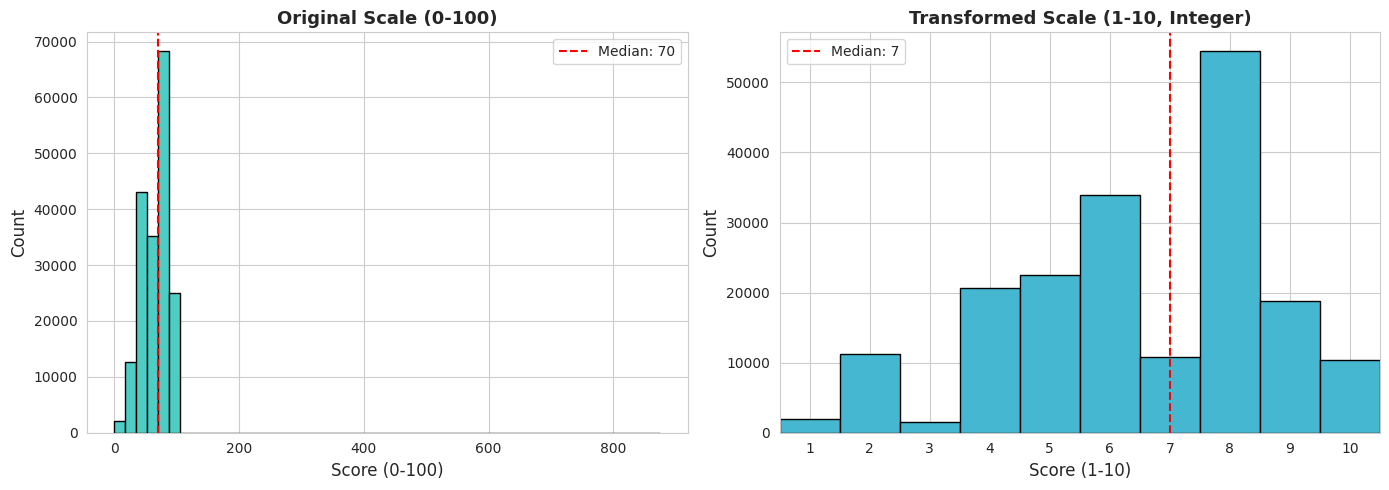

In [86]:
# Parsowanie ocen do skali 0-100, a następnie na 1-10 (pierwsza skala służy do wizualizacji)
print("\nParsowanie ocen do skali 1-10")

GRADE_MAP = {
    "A+": 100, "A": 95, "A-": 90,
    "B+": 87,  "B": 83, "B-": 80,
    "C+": 77,  "C": 73, "C-": 70,
    "D+": 67,  "D": 63, "D-": 60,
    "F": 50
}

def score_to_0_100(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip()

    m = re.match(r"^(\d+(?:\.\d+)?)\s*%$", s)
    if m:
        return float(m.group(1))

    m = re.match(r"^(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)$", s)
    if m:
        num, den = float(m.group(1)), float(m.group(2))
        if den > 0:
            return 100.0 * num / den

    m = re.match(r"^(\d+(?:\.\d+)?)$", s)
    if m:
        num = float(m.group(1))
        if num <= 5:
            return 100.0 * num / 5.0
        elif num <= 10:
            return num * 10.0
        elif num <= 100:
            return num

    if s.upper().strip() in GRADE_MAP:
        return float(GRADE_MAP[s.upper().strip()])

    return np.nan

df["score_100"] = df["review_score"].apply(score_to_0_100)
df["score_10"] = (df["score_100"] / 10.0).round().clip(1, 10).astype('Int64')

original_count = df["review_score"].notna().sum()
parsed_count = df["score_10"].notna().sum()
success_rate = (parsed_count / original_count * 100) if original_count > 0 else 0

print(f"   Oryginalne oceny: {original_count}")
print(f"   Sparsowane: {parsed_count} ({success_rate:.1f}%)")
print(f"\n   Rozkład ocen (1-10):")
print(f"      Średnia: {df['score_10'].mean():.1f}")
print(f"      Mediana: {df['score_10'].median():.0f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df["score_100"].dropna().hist(bins=50, ax=axes[0], edgecolor='black', color='#4ECDC4')
axes[0].set_xlabel("Score (0-100)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_title("Original Scale (0-100)", fontsize=13, fontweight='bold')
axes[0].axvline(df["score_100"].median(), color='red', linestyle='--',
                label=f'Median: {df["score_100"].median():.0f}')
axes[0].legend()

df["score_10"].dropna().hist(bins=10, range=(0.5, 10.5), ax=axes[1],
                              edgecolor='black', color='#45B7D1', align='mid')
axes[1].set_xlabel("Score (1-10)", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_title("Transformed Scale (1-10, Integer)", fontsize=13, fontweight='bold')
axes[1].axvline(df["score_10"].median(), color='red', linestyle='--',
                label=f'Median: {df["score_10"].median():.0f}')
axes[1].legend()
axes[1].set_xticks(range(1, 11))
axes[1].set_xlim(0.5, 10.5)

plt.tight_layout()
plt.show()



Analiza n-gramów i log-odds
   Analizowanych recenzji: 178134
   Zakres ocen: 1 - 10

   TOP 30 n-gramów zwiększających ocenę:
       ngram  log_odds
    never loses  5.466490
    masterpiece  4.676523
   never boring  4.198828
      marvelous  4.146900
       not only  4.095333
      cant wait  3.858472
      kill bill  3.838433
        sublime  3.832920
      afraid to  3.789916
      even when  3.713866
      be missed  3.702133
        perfect  3.635244
     perfection  3.600415
        hell of  3.581939
    ratatouille  3.554853
      wonderful  3.538334
    masterfully  3.519615
    brilliantly  3.504972
       the void  3.503113
     unmissable  3.495483
   exhilarating  3.494096
        no less  3.493981
     quite like  3.480651
       at worst  3.469376
    oscarworthy  3.453654
   electrifying  3.426488
    even better  3.426298
      brilliant  3.412966
   blade runner  3.407611
         leighs  3.402606

   TOP 30 n-gramów obniżających ocenę:
         ngram  log_odds
    

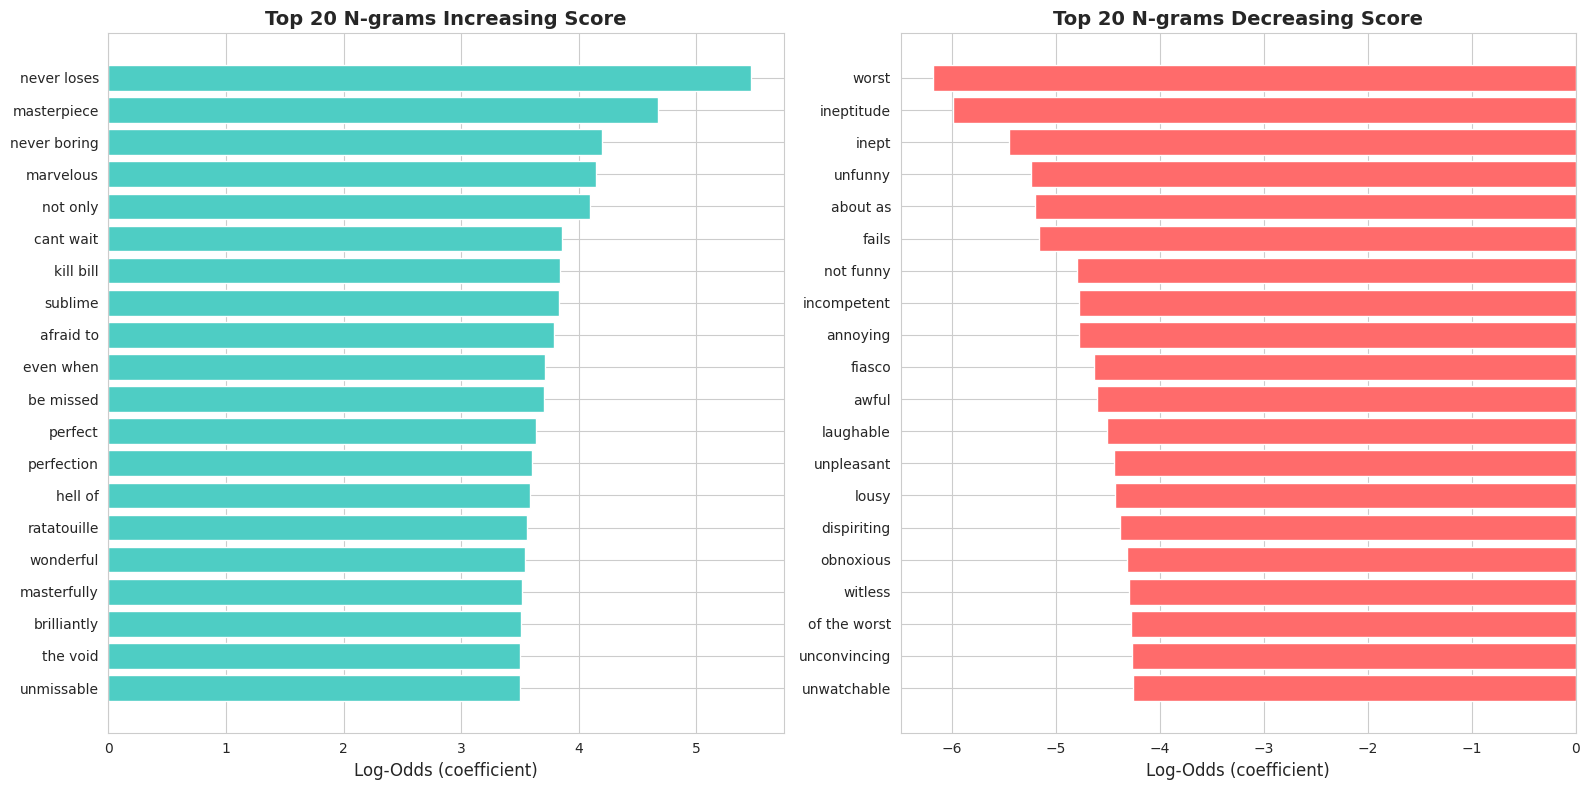


   Łączna liczba cech: 20000


In [87]:
# Analiza n-gramów i log-odds
print("\nAnaliza n-gramów i log-odds")

df_for_ngrams = df[
    df["score_10"].notna() &
    (df["text_cleaned"].str.strip() != "")
].copy()

print(f"   Analizowanych recenzji: {len(df_for_ngrams)}")
print(f"   Zakres ocen: {df_for_ngrams['score_10'].min():.0f} - {df_for_ngrams['score_10'].max():.0f}")

vectorizer_ngrams = TfidfVectorizer(
    ngram_range=(1, 3), #Używane są uni-gramy, bi-gramy oraz tri-gramy
    min_df=10,
    max_features=20000,
    sublinear_tf=True
)

X_ngrams = vectorizer_ngrams.fit_transform(df_for_ngrams["text_cleaned"])
y_ngrams = df_for_ngrams["score_10"].astype(float)

ridge_ngrams = Ridge(alpha=1.0)
ridge_ngrams.fit(X_ngrams, y_ngrams)

feature_names = vectorizer_ngrams.get_feature_names_out()
coefficients = ridge_ngrams.coef_

ngram_weights = pd.DataFrame({
    'ngram': feature_names,
    'log_odds': coefficients
})

ngram_weights = ngram_weights.sort_values('log_odds', ascending=False)

print("\n   TOP 30 n-gramów zwiększających ocenę:")
print(ngram_weights.head(30).to_string(index=False).replace('\n', '\n   '))

print("\n   TOP 30 n-gramów obniżających ocenę:")
print(ngram_weights.tail(30).to_string(index=False).replace('\n', '\n   '))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_positive = ngram_weights.head(20)
axes[0].barh(top_positive['ngram'], top_positive['log_odds'], color='#4ECDC4')
axes[0].set_xlabel('Log-Odds (coefficient)', fontsize=12)
axes[0].set_title('Top 20 N-grams Increasing Score', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

top_negative = ngram_weights.tail(20).sort_values('log_odds')
axes[1].barh(top_negative['ngram'], top_negative['log_odds'], color='#FF6B6B')
axes[1].set_xlabel('Log-Odds (coefficient)', fontsize=12)
axes[1].set_title('Top 20 N-grams Decreasing Score', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n   Łączna liczba cech: {len(feature_names)}")


Trening modelu regresji logistycznej do predykcji ocen na bazie tekstu


Trening modelu regresji: tekst → ocena (1-10)
   Dataset: 178134 recenzji
   Zakres ocen: 1.0 - 10.0
   Train: 142507 | Test: 35627

   Train MAE: 1.175
   Test MAE:  1.371
   Test RMSE: 1.734
   Test R²:   0.352

   Tolerancja predykcji:
      ±0.5 punktu: 25.3%
      ±1.0 punktu: 46.4%
      ±1.5 punktu: 63.8%


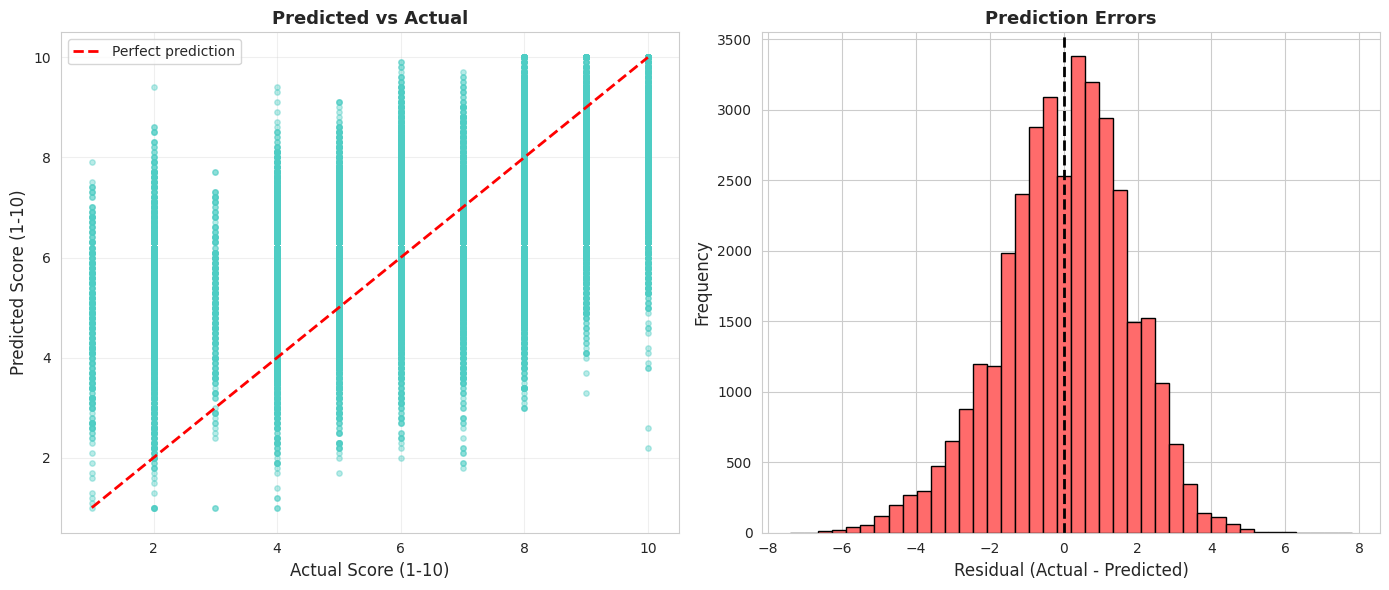

In [88]:
# Trening modelu regresji: tekst → ocena (1-10)
print("\nTrening modelu regresji: tekst → ocena (1-10)")

df_with_score = df[
    df["score_10"].notna() &
    (df["text_cleaned"].str.strip() != "")
].copy()

print(f"   Dataset: {len(df_with_score)} recenzji")
print(f"   Zakres ocen: {df_with_score['score_10'].min():.1f} - {df_with_score['score_10'].max():.1f}")

X = df_with_score["text_cleaned"]
y = df_with_score["score_10"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Train: {len(X_train)} | Test: {len(X_test)}")

regressor = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000)),
    ("ridge", Ridge(alpha=1.0))
])

regressor.fit(X_train, y_train)

pred_train = regressor.predict(X_train).clip(1, 10).round(1)
pred_test = regressor.predict(X_test).clip(1, 10).round(1)

mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
rmse_test = mean_squared_error(y_test, pred_test) ** 0.5
r2_test = r2_score(y_test, pred_test)

print(f"\n   Train MAE: {mae_train:.3f}")
print(f"   Test MAE:  {mae_test:.3f}")
print(f"   Test RMSE: {rmse_test:.3f}")
print(f"   Test R²:   {r2_test:.3f}")

# Tolerancja predykcji
within_05 = (np.abs(y_test - pred_test) <= 0.5).mean()
within_10 = (np.abs(y_test - pred_test) <= 1.0).mean()
within_15 = (np.abs(y_test - pred_test) <= 1.5).mean()

print(f"\n   Tolerancja predykcji:")
print(f"      ±0.5 punktu: {within_05:.1%}")
print(f"      ±1.0 punktu: {within_10:.1%}")
print(f"      ±1.5 punktu: {within_15:.1%}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, pred_test, alpha=0.4, s=15, color='#4ECDC4')
axes[0].plot([1, 10], [1, 10], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel("Actual Score (1-10)", fontsize=12)
axes[0].set_ylabel("Predicted Score (1-10)", fontsize=12)
axes[0].set_title("Predicted vs Actual", fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0.5, 10.5)
axes[0].set_ylim(0.5, 10.5)

residuals = y_test - pred_test
axes[1].hist(residuals, bins=40, edgecolor='black', color='#FF6B6B')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Prediction Errors", fontsize=13, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [89]:
# Predykcja dla całego datasetu
print("\nPredykcja dla całego datasetu")

df["predicted_score_10"] = np.nan
mask = df["text_cleaned"].notna() & (df["text_cleaned"].str.strip() != "")

df.loc[mask, "predicted_score_10"] = (
    regressor.predict(df.loc[mask, "text_cleaned"])
    .clip(1, 10)
    .round(1)
)

print(f"   Predykcje dla {mask.sum()} recenzji")
print(f"\n   Rozkład predykcji:")
print(f"      Średnia: {df['predicted_score_10'].mean():.2f}")
print(f"      Mediana: {df['predicted_score_10'].median():.1f}")
print(f"      Min-Max: {df['predicted_score_10'].min():.1f} - {df['predicted_score_10'].max():.1f}")

df["score_residual"] = df["score_10"] - df["predicted_score_10"]

print(f"\n   Błąd predykcji (residuals):")
print(f"      Średnia: {df['score_residual'].mean():.3f}")
print(f"      Mediana: {df['score_residual'].median():.3f}")
print(f"      Odch. std: {df['score_residual'].std():.3f}")


Predykcja dla całego datasetu
   Predykcje dla 280632 recenzji

   Rozkład predykcji:
      Średnia: 6.52
      Mediana: 6.6
      Min-Max: 1.0 - 10.0

   Błąd predykcji (residuals):
      Średnia: 0.000
      Mediana: 0.100
      Odch. std: 1.538


#Ocena podejrzeń wobec danego recenzenta

Sprawdzanie największej aktywności recenzentów w oknie tygodniowym (zakładamy że profesjonalny recenzent da radę dać recenzje 10 filmom w trakcie tygodnia maks)


Detekcja burst activity recenzentów
   Burst 7d (>10 recenzji): 42128 (14.8%)
   Burst znormalizowany (>30% w 7d): 18187 (6.4%)
   Łącznie burst: 46360 (16.3%)

   Recenzenci z burst: 2459

   TOP 20 recenzentów z największym burst:
       critic_name  max_burst_7d  max_burst_ratio first_review last_review  total_reviews
       Roger Ebert          2456         0.382733   2000-01-01  2018-07-10           4683
James Berardinelli          1709         0.325338   2000-01-01  2018-12-13           1202
       Susan Stark           922         0.668600   2000-01-01  2008-10-18            324
   Owen Gleiberman           829         0.236115   2000-01-01  2017-09-11            439
    Desson Thomson           687         0.365815   2000-01-01  2005-03-18            776
     Variety Staff           500         0.291545   2001-02-13  2012-02-23           1319
      Janet Maslin           465         0.459941   2000-01-01  2005-05-14            937
      Rita Kempley           441         0.700

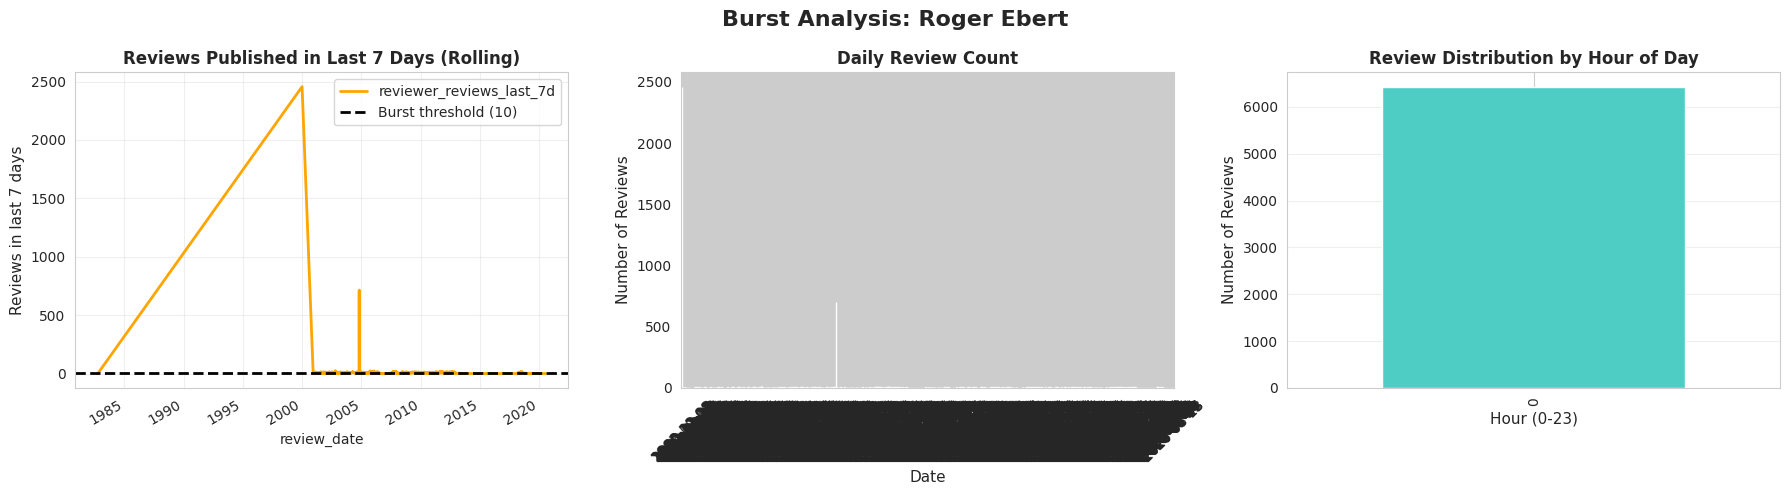


   Analiza dla 'Roger Ebert':
      Łączne recenzje: 6417
      Peak 7d burst: 2456
      Max burst ratio: 38.3%
      Recenzje w burst: 4707
      Zakres aktywności: 13798 dni

   Porównanie thresholds (7 dni):
   Threshold    Recenzje     % Recenzji      Recenzenci  
   >5           104633       36.86          % 591         
   >10          42128        14.84          % 350         
   >15          30365        10.70          % 246         
   >20          27803        9.79           % 199         
   >30          25165        8.87           % 142         
   >50          22255        7.84           % 92          

   Statystyki burst (7 dni):
      Średnia: 55.90
      Mediana: 4.0
      95 percentyl: 181.0
      Max: 2456


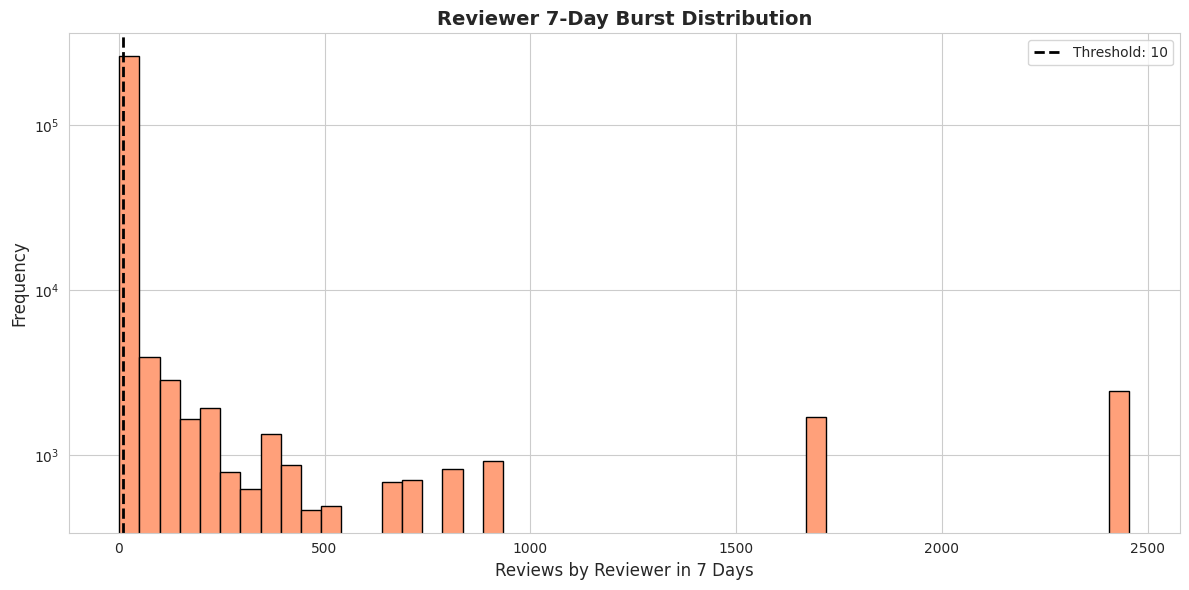

In [90]:
# Detekcja burst activity recenzentów (7 dni)
print("\nDetekcja burst activity recenzentów")

def calculate_reviewer_burst(group):
    group = group.sort_values('review_date').copy()
    total_reviews = len(group)

    counts_7d = []

    for idx, row in group.iterrows():
        current_time = row['review_date']
        window_7d_start = current_time - timedelta(days=7)
        count_7d = ((group['review_date'] >= window_7d_start) &
                    (group['review_date'] <= current_time)).sum()
        counts_7d.append(count_7d)

    group['reviewer_reviews_last_7d'] = counts_7d
    group['reviewer_burst_ratio_7d'] = group['reviewer_reviews_last_7d'] / total_reviews

    return group

df = df.groupby('critic_name', group_keys=False).apply(calculate_reviewer_burst)

# Flagi burst (threshold: >10 recenzji w 7 dni)
df['is_reviewer_burst_7d'] = df['reviewer_reviews_last_7d'] > 10
df['is_reviewer_burst_normalized'] = df['reviewer_burst_ratio_7d'] > 0.3

df['is_reviewer_burst_any'] = (
    df['is_reviewer_burst_7d'] |
    df['is_reviewer_burst_normalized']
)

print(f"   Burst 7d (>10 recenzji): {df['is_reviewer_burst_7d'].sum()} ({df['is_reviewer_burst_7d'].mean()*100:.1f}%)")
print(f"   Burst znormalizowany (>30% w 7d): {df['is_reviewer_burst_normalized'].sum()} ({df['is_reviewer_burst_normalized'].mean()*100:.1f}%)")
print(f"   Łącznie burst: {df['is_reviewer_burst_any'].sum()} ({df['is_reviewer_burst_any'].mean()*100:.1f}%)")

# Analiza recenzentów z burst
bursty_reviewers = df[df['is_reviewer_burst_any']].groupby('critic_name').agg({
    'reviewer_reviews_last_7d': 'max',
    'reviewer_burst_ratio_7d': 'max',
    'review_date': ['min', 'max'],
    'review_content': 'count'
}).reset_index()

bursty_reviewers.columns = ['critic_name', 'max_burst_7d', 'max_burst_ratio',
                             'first_review', 'last_review', 'total_reviews']
bursty_reviewers = bursty_reviewers.sort_values('max_burst_7d', ascending=False)

print(f"\n   Recenzenci z burst: {len(bursty_reviewers)}")
print(f"\n   TOP 20 recenzentów z największym burst:")
print(bursty_reviewers.head(20).to_string(index=False))

# Wizualizacja przykładowego recenzenta
if len(bursty_reviewers) > 0:
    example_reviewer = bursty_reviewers.iloc[0]['critic_name']
    reviewer_data = df[df['critic_name'] == example_reviewer].sort_values('review_date')

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Burst Analysis: {example_reviewer}', fontsize=16, fontweight='bold')

    # Plot 1: Time series - reviews in last 7d
    reviewer_data.set_index('review_date')['reviewer_reviews_last_7d'].plot(
        ax=axes[0], color='orange', linewidth=2
    )
    axes[0].axhline(y=10, color='black', linestyle='--',
                    linewidth=2, label='Burst threshold (10)')
    axes[0].set_title('Reviews Published in Last 7 Days (Rolling)', fontweight='bold')
    axes[0].set_ylabel('Reviews in last 7 days', fontsize=11)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Daily distribution
    daily_counts = reviewer_data['review_date'].dt.date.value_counts().sort_index()
    daily_counts.plot(kind='bar', ax=axes[1], color='steelblue', width=0.8)
    axes[1].set_title('Daily Review Count', fontweight='bold')
    axes[1].set_ylabel('Number of Reviews', fontsize=11)
    axes[1].set_xlabel('Date', fontsize=11)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Plot 3: Hourly distribution
    if pd.api.types.is_datetime64_any_dtype(reviewer_data['review_date']):
        hourly_counts = reviewer_data['review_date'].dt.hour.value_counts().sort_index()
        hourly_counts.plot(kind='bar', ax=axes[2], color='#4ECDC4', width=0.8)
        axes[2].set_title('Review Distribution by Hour of Day', fontweight='bold')
        axes[2].set_ylabel('Number of Reviews', fontsize=11)
        axes[2].set_xlabel('Hour (0-23)', fontsize=11)
        axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print(f"\n   Analiza dla '{example_reviewer}':")
    print(f"      Łączne recenzje: {len(reviewer_data)}")
    print(f"      Peak 7d burst: {reviewer_data['reviewer_reviews_last_7d'].max()}")
    print(f"      Max burst ratio: {reviewer_data['reviewer_burst_ratio_7d'].max()*100:.1f}%")
    print(f"      Recenzje w burst: {reviewer_data['is_reviewer_burst_any'].sum()}")
    print(f"      Zakres aktywności: {(reviewer_data['review_date'].max() - reviewer_data['review_date'].min()).days} dni")

# Porównanie thresholds
print("\n   Porównanie thresholds (7 dni):")
print(f"   {'Threshold':<12} {'Recenzje':<12} {'% Recenzji':<15} {'Recenzenci':<12}")

thresholds_7d = [5, 10, 15, 20, 30, 50]

for thresh in thresholds_7d:
    review_count = (df['reviewer_reviews_last_7d'] > thresh).sum()
    review_pct = review_count / len(df) * 100
    reviewer_count = df[df['reviewer_reviews_last_7d'] > thresh]['critic_name'].nunique()
    print(f"   >{thresh:<11} {review_count:<12} {review_pct:<15.2f}% {reviewer_count:<12}")

# Statystyki burst
print(f"\n   Statystyki burst (7 dni):")
print(f"      Średnia: {df['reviewer_reviews_last_7d'].mean():.2f}")
print(f"      Mediana: {df['reviewer_reviews_last_7d'].median():.1f}")
print(f"      95 percentyl: {df['reviewer_reviews_last_7d'].quantile(0.95):.1f}")
print(f"      Max: {df['reviewer_reviews_last_7d'].max():.0f}")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))

df['reviewer_reviews_last_7d'].hist(bins=50, ax=ax, color='#FFA07A', edgecolor='black')
ax.axvline(10, color='black', linestyle='--', linewidth=2, label='Threshold: 10')
ax.set_xlabel('Reviews by Reviewer in 7 Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Reviewer 7-Day Burst Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()


In [91]:
#Statystyki recenzentów

print("\nObliczanie statystyk krytyków...")

reviewer_stats = df.groupby('critic_name').agg(
    review_count         = ('review_date', 'count'),
    first_review         = ('review_date', 'min'),
    last_review          = ('review_date', 'max'),
    positive_ratio       = ('review_type', lambda x: (x == 'Fresh').mean()),
    unique_movies        = ('movie_title', 'nunique'),

    critic_mean_score_10 = ('score_10', 'mean'),
    critic_std_score_10  = ('score_10', 'std'),
    critic_mean_length   = ('text_length_cleaned', 'mean'),

).reset_index()

# Obliczenia pomocnicze
reviewer_stats['deviation_from_mean'] = np.abs(
    reviewer_stats['critic_mean_score_10'] - df['score_10'].mean()
)
reviewer_stats['days_active'] = (
    reviewer_stats['last_review'] - reviewer_stats['first_review']
).dt.days

reviewer_stats['is_suspicious'] = (
    (reviewer_stats['review_count'] < 5) |
    (reviewer_stats['positive_ratio'] > 0.95) |
    (reviewer_stats['positive_ratio'] < 0.05) |
    (reviewer_stats['days_active'] < 30)
)

# Merge z głównym df
df = df.merge(reviewer_stats, on='critic_name', how='left')

print(f"  Dodano kolumny: critic_mean_score_10, critic_std_score_10, critic_mean_length")



Obliczanie statystyk krytyków...
  Dodano kolumny: critic_mean_score_10, critic_std_score_10, critic_mean_length


In [92]:
print("\nObliczanie cech per recenzja (Z-score, consensus_diff, sentiment_diff)...")

# 1. Z-score oceny względem typowego krytyka
min_std = 0.5
df['critic_std_safe'] = df['critic_std_score_10'].fillna(min_std).clip(lower=min_std)
df['z_score_critic'] = (df['score_10'] - df['critic_mean_score_10']) / df['critic_std_safe']

# 2. Różnica sentiment vs rzeczywista ocena
df['sentiment_diff'] = df['score_residual'].abs()

# 3. Odchylenie od tomatometer
df['consensus_score_10'] = (df['tomatometer_rating'] / 10.0).clip(0, 10)
df['consensus_diff'] = (df['score_10'] - df['consensus_score_10']).abs()

# 4.odchylenie od średniej producenta
publisher_col = 'publisher_name'
if publisher_col in df.columns:
    publisher_stats = df.groupby(publisher_col).agg(
        publisher_mean_score_10 = ('score_10', 'mean'),
        publisher_std_score_10  = ('score_10', 'std')
    ).reset_index()
    df = df.merge(publisher_stats, on=publisher_col, how='left')
    df['publisher_std_safe'] = df['publisher_std_score_10'].fillna(min_std).clip(lower=min_std)
    df['publisher_z_score'] = (
        (df['score_10'] - df['publisher_mean_score_10']) / df['publisher_std_safe']
    ).abs()
else:
    df['publisher_z_score'] = 0.0

print(f"  Dodano: z_score_critic, sentiment_diff, consensus_diff, publisher_z_score")



Obliczanie cech per recenzja (Z-score, consensus_diff, sentiment_diff)...
  Dodano: z_score_critic, sentiment_diff, consensus_diff, publisher_z_score


In [93]:
print("\nObliczanie bias_score (weighted combination)...")

from sklearn.preprocessing import StandardScaler

bias_components = ['z_score_critic', 'sentiment_diff', 'consensus_diff', 'publisher_z_score']

# Standaryzacja
scaler_bias = StandardScaler()
df_bias_values = scaler_bias.fit_transform(df[bias_components].fillna(0.0))

# Wagi
w = np.array([0.4, 0.2, 0.3, 0.1])  # z_score, sentiment, consensus, publisher

bias_raw = df_bias_values @ w
from sklearn.preprocessing import minmax_scale
df['bias_score'] = minmax_scale(bias_raw, feature_range=(1, 10))

print(f"  Dodano kolumnę: bias_score (1-10)")
print(f"  Średnia: {df['bias_score'].mean():.2f}")
print(f"  Mediana: {df['bias_score'].median():.2f}")
print(f"  Zakres: {df['bias_score'].min():.2f} - {df['bias_score'].max():.2f}")



Obliczanie bias_score (weighted combination)...
  Dodano kolumnę: bias_score (1-10)
  Średnia: 4.66
  Mediana: 4.41
  Zakres: 1.00 - 10.00



Wizualizacja statystyk recenzentów


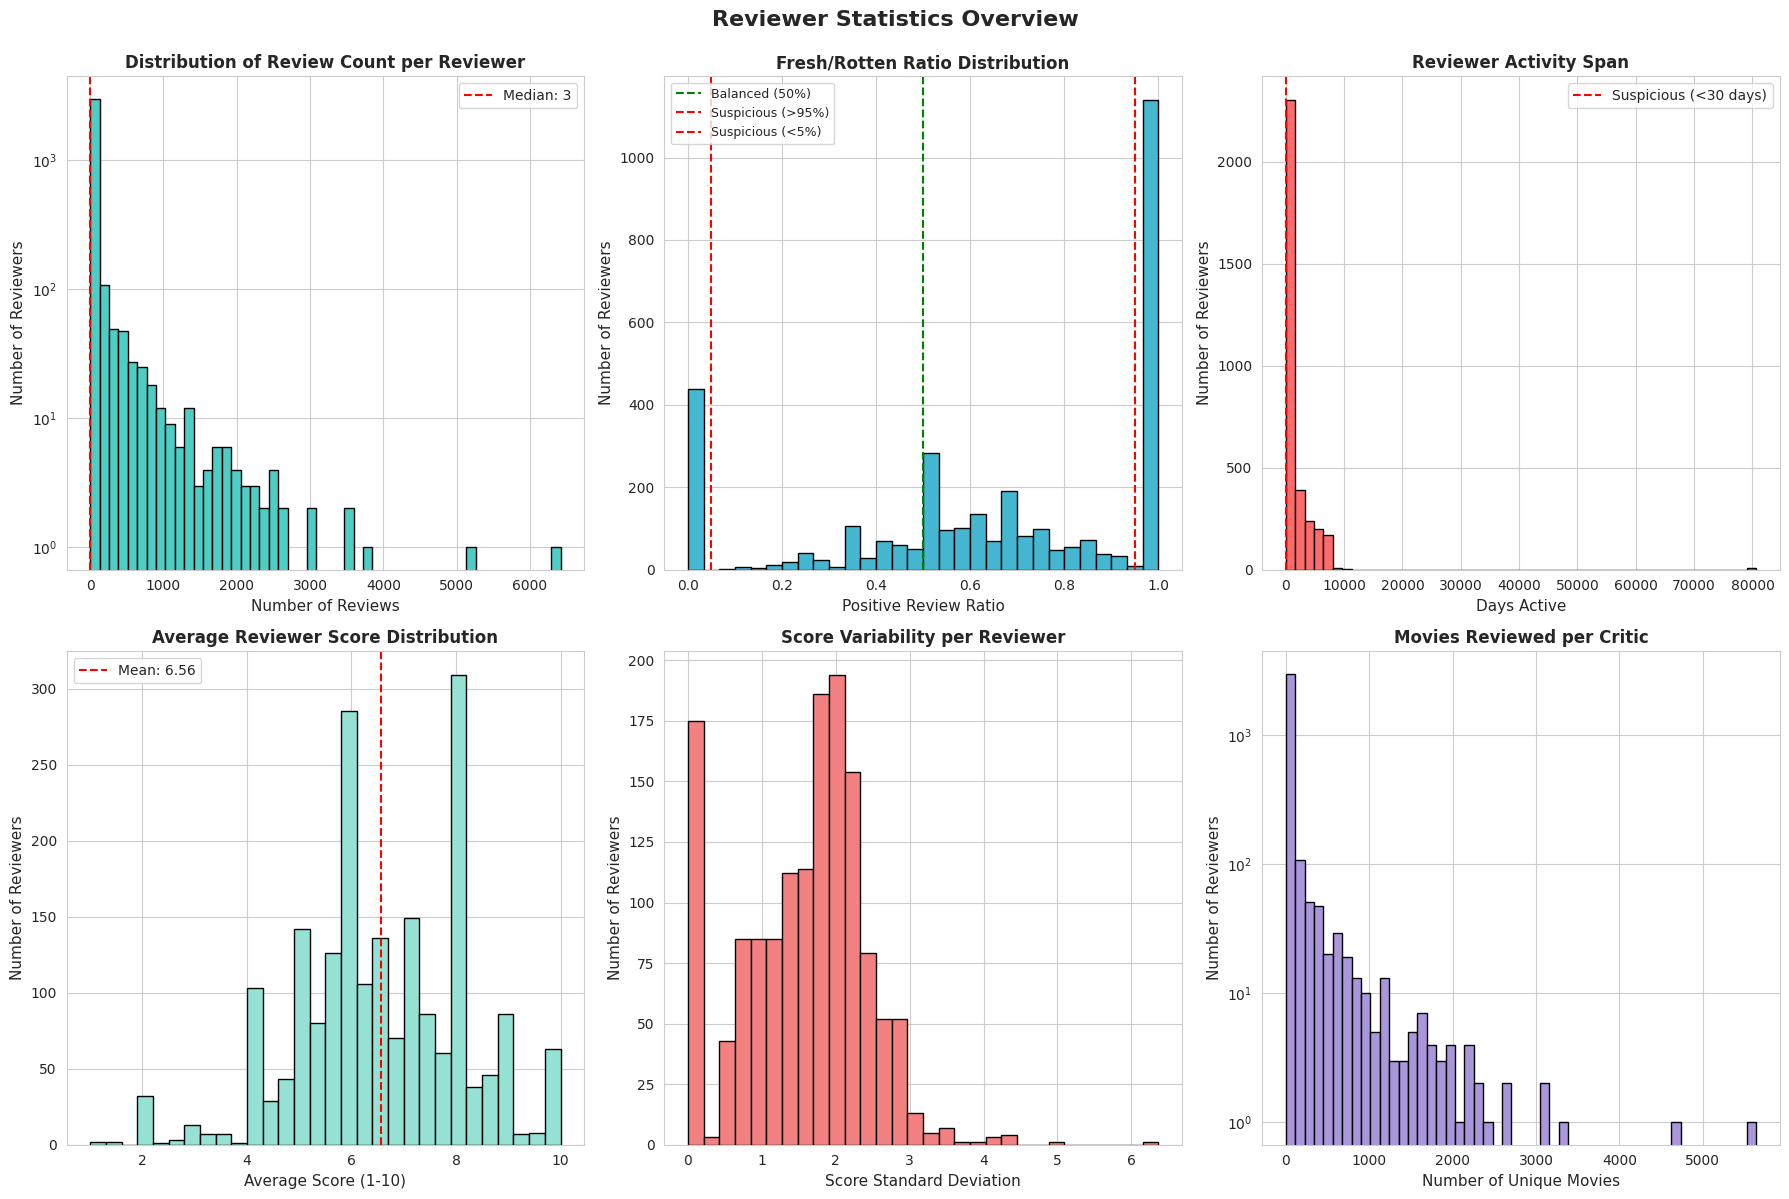

   Podejrzani: 1981 (59.6%)
   Normalni: 1343 (40.4%)


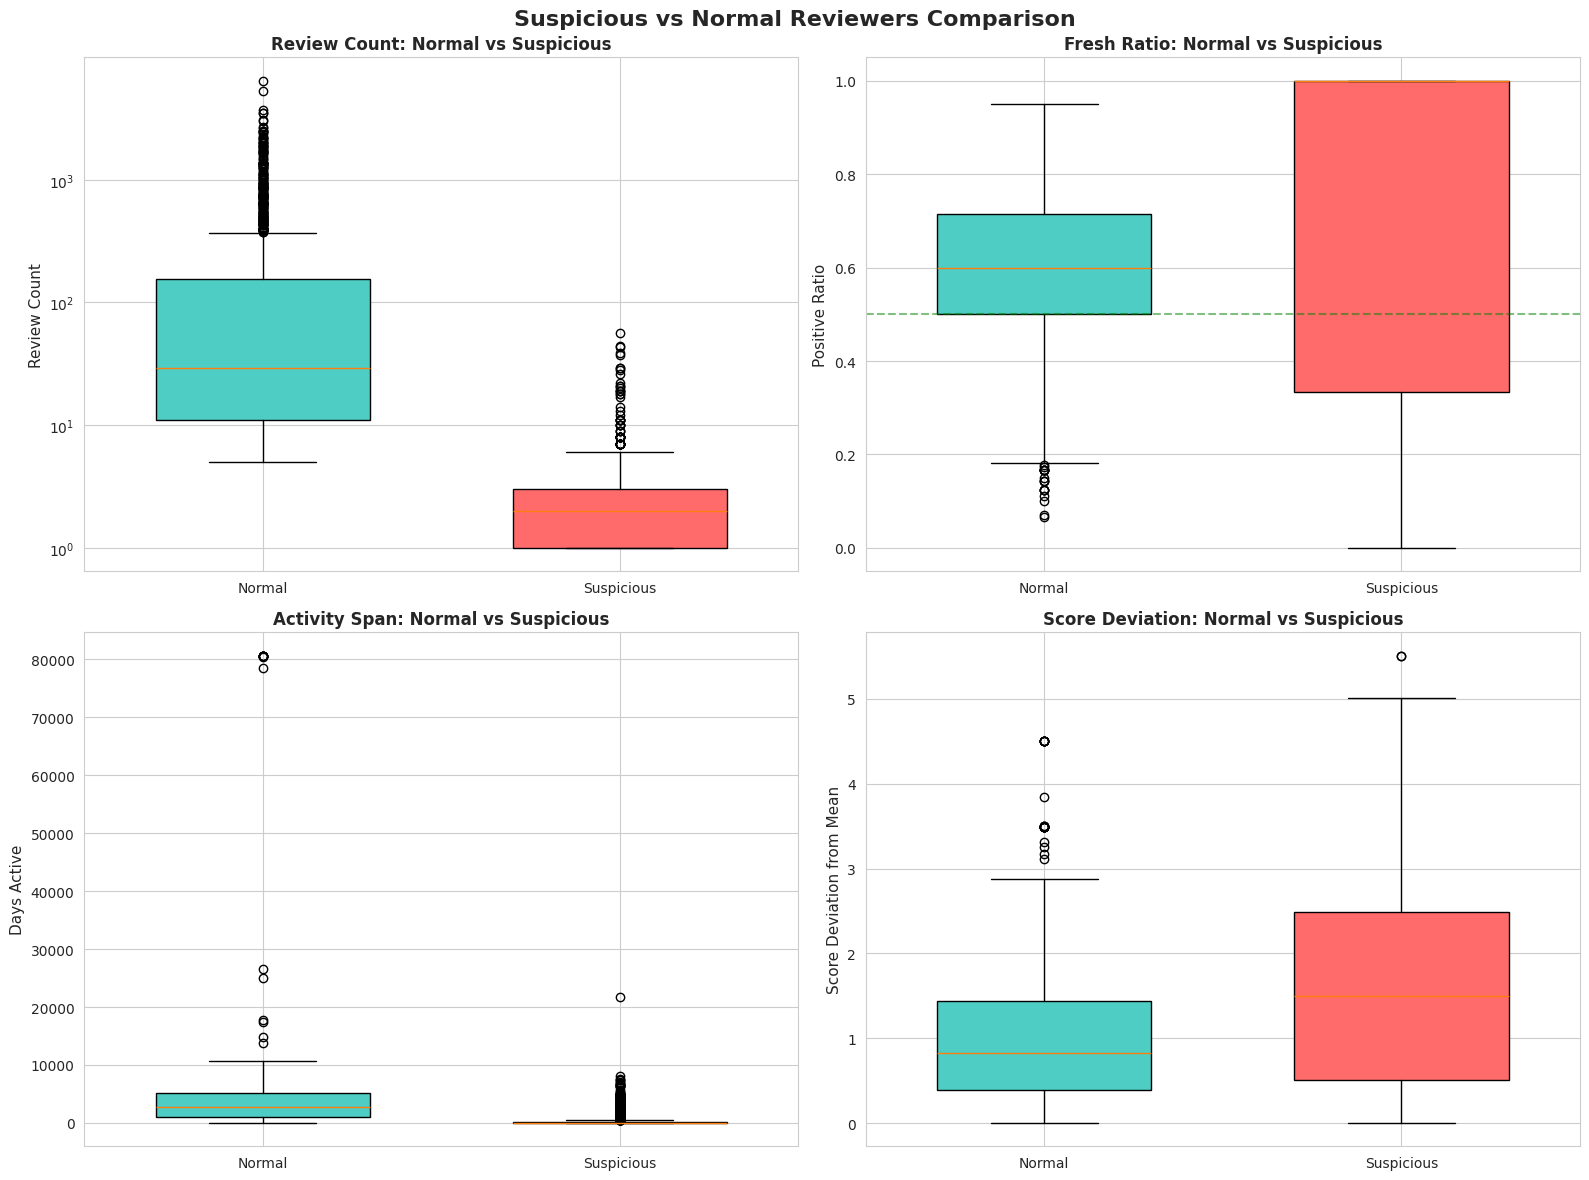

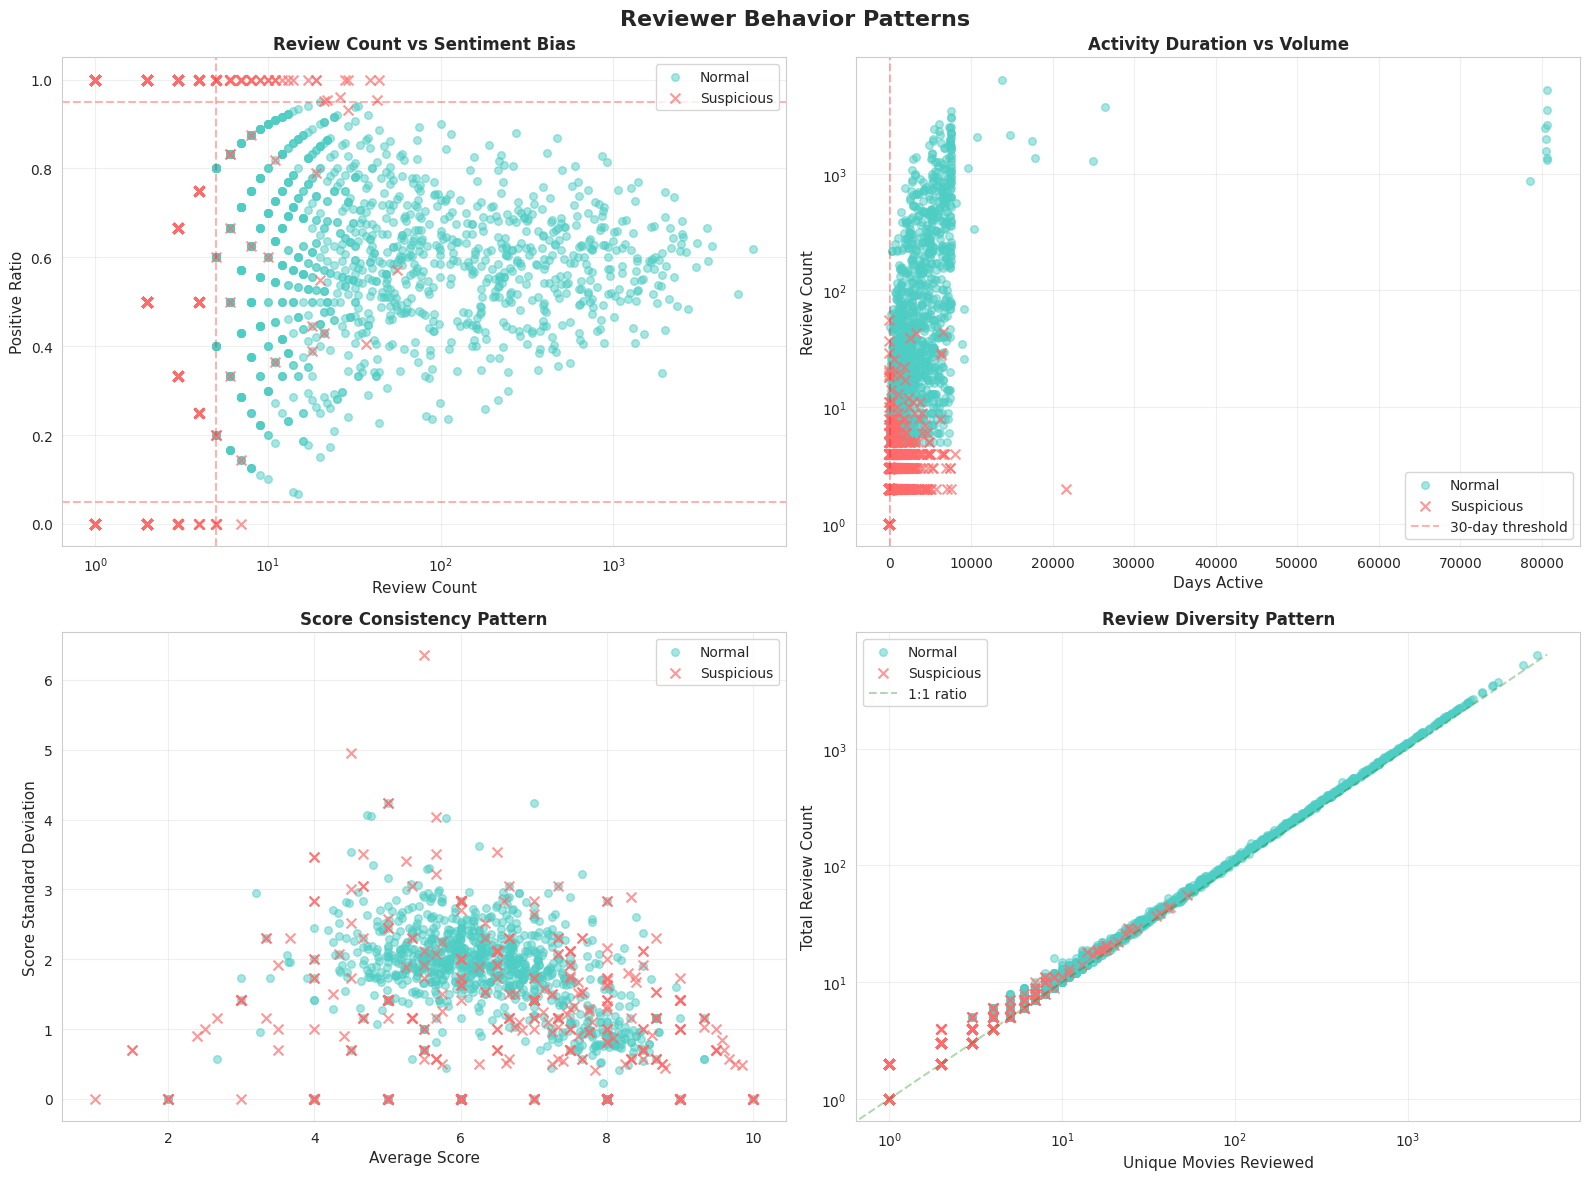

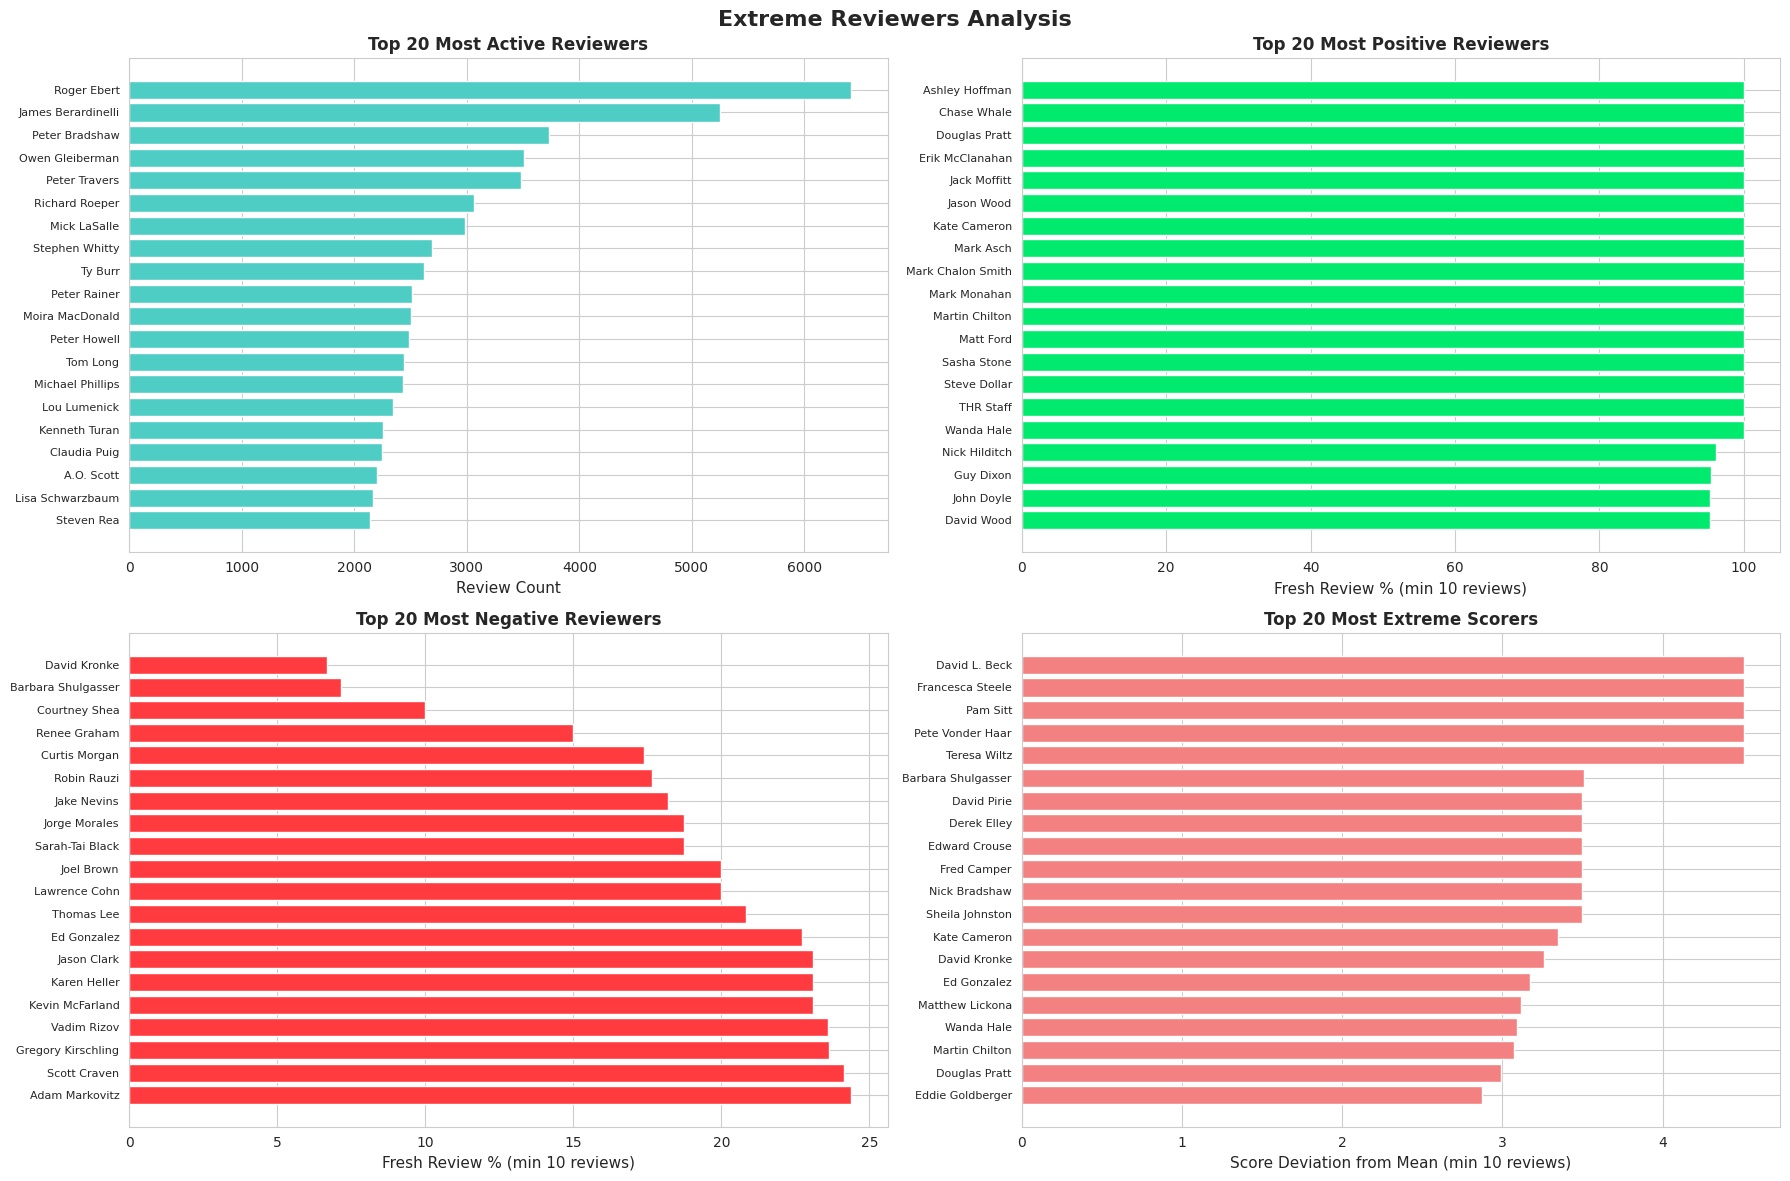


Podsumowanie statystyk recenzentów:
                Metric All Reviewers Normal  Suspicious
       Total Reviewers          3324   1343        1981
  Suspicious Reviewers  1981 (59.6%)      - 1981 (100%)
Avg Reviews per Critic          85.4  208.0         2.3
        Median Reviews             3     29           2
    Avg Positive Ratio         64.8%  59.8%       68.3%
       Avg Days Active          1727   3692         395
     Avg Unique Movies          76.2  185.7         2.1
   Avg Score Deviation          1.29   0.98        1.59


In [94]:
# Wizualizacja statystyk recenzentów
print("\nWizualizacja statystyk recenzentów")

sns.set_style('whitegrid')

# VIZ 1: Podstawowe metryki
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Reviewer Statistics Overview', fontsize=16, fontweight='bold', y=0.995)

axes[0, 0].hist(reviewer_stats['review_count'], bins=50, color='#4ECDC4', edgecolor='black')
axes[0, 0].axvline(reviewer_stats['review_count'].median(), color='red',
                   linestyle='--', label=f"Median: {reviewer_stats['review_count'].median():.0f}")
axes[0, 0].set_xlabel('Number of Reviews', fontsize=11)
axes[0, 0].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 0].set_title('Distribution of Review Count per Reviewer', fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()

axes[0, 1].hist(reviewer_stats['positive_ratio'], bins=30, color='#45B7D1', edgecolor='black')
axes[0, 1].axvline(0.5, color='green', linestyle='--', label='Balanced (50%)')
axes[0, 1].axvline(0.95, color='red', linestyle='--', label='Suspicious (>95%)')
axes[0, 1].axvline(0.05, color='red', linestyle='--', label='Suspicious (<5%)')
axes[0, 1].set_xlabel('Positive Review Ratio', fontsize=11)
axes[0, 1].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 1].set_title('Fresh/Rotten Ratio Distribution', fontweight='bold')
axes[0, 1].legend(fontsize=9)

axes[0, 2].hist(reviewer_stats['days_active'], bins=50, color='#FF6B6B', edgecolor='black')
axes[0, 2].axvline(30, color='red', linestyle='--', label='Suspicious (<30 days)')
axes[0, 2].set_xlabel('Days Active', fontsize=11)
axes[0, 2].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 2].set_title('Reviewer Activity Span', fontweight='bold')
axes[0, 2].legend()

axes[1, 0].hist(reviewer_stats['critic_mean_score_10'].dropna(), bins=30, color='#95E1D3', edgecolor='black')
axes[1, 0].axvline(reviewer_stats['critic_mean_score_10'].mean(), color='red',
                   linestyle='--', label=f"Mean: {reviewer_stats['critic_mean_score_10'].mean():.2f}")
axes[1, 0].set_xlabel('Average Score (1-10)', fontsize=11)
axes[1, 0].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 0].set_title('Average Reviewer Score Distribution', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].hist(reviewer_stats['critic_std_score_10'].dropna(), bins=30, color='#F38181', edgecolor='black')
axes[1, 1].set_xlabel('Score Standard Deviation', fontsize=11)
axes[1, 1].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 1].set_title('Score Variability per Reviewer', fontweight='bold')

axes[1, 2].hist(reviewer_stats['unique_movies'], bins=50, color='#AA96DA', edgecolor='black')
axes[1, 2].set_xlabel('Number of Unique Movies', fontsize=11)
axes[1, 2].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 2].set_title('Movies Reviewed per Critic', fontweight='bold')
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

# VIZ 2: Suspicious vs Normal
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Suspicious vs Normal Reviewers Comparison', fontsize=16, fontweight='bold')

suspicious = reviewer_stats[reviewer_stats['is_suspicious']]
normal = reviewer_stats[~reviewer_stats['is_suspicious']]

print(f"   Podejrzani: {len(suspicious)} ({len(suspicious)/len(reviewer_stats)*100:.1f}%)")
print(f"   Normalni: {len(normal)} ({len(normal)/len(reviewer_stats)*100:.1f}%)")

data_to_plot = [normal['review_count'], suspicious['review_count']]
bp1 = axes[0, 0].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp1['boxes'][0].set_facecolor('#4ECDC4')
bp1['boxes'][1].set_facecolor('#FF6B6B')
axes[0, 0].set_ylabel('Review Count', fontsize=11)
axes[0, 0].set_title('Review Count: Normal vs Suspicious', fontweight='bold')
axes[0, 0].set_yscale('log')

data_to_plot = [normal['positive_ratio'], suspicious['positive_ratio']]
bp2 = axes[0, 1].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp2['boxes'][0].set_facecolor('#4ECDC4')
bp2['boxes'][1].set_facecolor('#FF6B6B')
axes[0, 1].set_ylabel('Positive Ratio', fontsize=11)
axes[0, 1].set_title('Fresh Ratio: Normal vs Suspicious', fontweight='bold')
axes[0, 1].axhline(0.5, color='green', linestyle='--', alpha=0.5)

data_to_plot = [normal['days_active'], suspicious['days_active']]
bp3 = axes[1, 0].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp3['boxes'][0].set_facecolor('#4ECDC4')
bp3['boxes'][1].set_facecolor('#FF6B6B')
axes[1, 0].set_ylabel('Days Active', fontsize=11)
axes[1, 0].set_title('Activity Span: Normal vs Suspicious', fontweight='bold')

data_to_plot = [normal['deviation_from_mean'].dropna(), suspicious['deviation_from_mean'].dropna()]
bp4 = axes[1, 1].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp4['boxes'][0].set_facecolor('#4ECDC4')
bp4['boxes'][1].set_facecolor('#FF6B6B')
axes[1, 1].set_ylabel('Score Deviation from Mean', fontsize=11)
axes[1, 1].set_title('Score Deviation: Normal vs Suspicious', fontweight='bold')

plt.tight_layout()
plt.show()

# VIZ 3: Scatter plots - zależności
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Reviewer Behavior Patterns', fontsize=16, fontweight='bold')

axes[0, 0].scatter(normal['review_count'], normal['positive_ratio'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[0, 0].scatter(suspicious['review_count'], suspicious['positive_ratio'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[0, 0].axhline(0.95, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axhline(0.05, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axvline(5, color='red', linestyle='--', alpha=0.3)
axes[0, 0].set_xlabel('Review Count', fontsize=11)
axes[0, 0].set_ylabel('Positive Ratio', fontsize=11)
axes[0, 0].set_title('Review Count vs Sentiment Bias', fontweight='bold')
axes[0, 0].set_xscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(normal['days_active'], normal['review_count'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[0, 1].scatter(suspicious['days_active'], suspicious['review_count'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[0, 1].axvline(30, color='red', linestyle='--', alpha=0.3, label='30-day threshold')
axes[0, 1].set_xlabel('Days Active', fontsize=11)
axes[0, 1].set_ylabel('Review Count', fontsize=11)
axes[0, 1].set_title('Activity Duration vs Volume', fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(normal['critic_mean_score_10'], normal['critic_std_score_10'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[1, 0].scatter(suspicious['critic_mean_score_10'], suspicious['critic_std_score_10'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[1, 0].set_xlabel('Average Score', fontsize=11)
axes[1, 0].set_ylabel('Score Standard Deviation', fontsize=11)
axes[1, 0].set_title('Score Consistency Pattern', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(normal['unique_movies'], normal['review_count'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[1, 1].scatter(suspicious['unique_movies'], suspicious['review_count'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
max_val = max(reviewer_stats['unique_movies'].max(), reviewer_stats['review_count'].max())
axes[1, 1].plot([0, max_val], [0, max_val], 'g--', alpha=0.3, label='1:1 ratio')
axes[1, 1].set_xlabel('Unique Movies Reviewed', fontsize=11)
axes[1, 1].set_ylabel('Total Review Count', fontsize=11)
axes[1, 1].set_title('Review Diversity Pattern', fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# VIZ 4: TOP/BOTTOM recenzenci
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Extreme Reviewers Analysis', fontsize=16, fontweight='bold')

top_active = reviewer_stats.nlargest(20, 'review_count')
axes[0, 0].barh(range(len(top_active)), top_active['review_count'], color='#4ECDC4')
axes[0, 0].set_yticks(range(len(top_active)))
axes[0, 0].set_yticklabels(top_active['critic_name'], fontsize=8)
axes[0, 0].set_xlabel('Review Count', fontsize=11)
axes[0, 0].set_title('Top 20 Most Active Reviewers', fontweight='bold')
axes[0, 0].invert_yaxis()

most_positive = reviewer_stats[reviewer_stats['review_count'] >= 10].nlargest(20, 'positive_ratio')
axes[0, 1].barh(range(len(most_positive)), most_positive['positive_ratio']*100, color='#00EA6E')
axes[0, 1].set_yticks(range(len(most_positive)))
axes[0, 1].set_yticklabels(most_positive['critic_name'], fontsize=8)
axes[0, 1].set_xlabel('Fresh Review % (min 10 reviews)', fontsize=11)
axes[0, 1].set_title('Top 20 Most Positive Reviewers', fontweight='bold')
axes[0, 1].invert_yaxis()

most_negative = reviewer_stats[reviewer_stats['review_count'] >= 10].nsmallest(20, 'positive_ratio')
axes[1, 0].barh(range(len(most_negative)), most_negative['positive_ratio']*100, color='#FF3B3F')
axes[1, 0].set_yticks(range(len(most_negative)))
axes[1, 0].set_yticklabels(most_negative['critic_name'], fontsize=8)
axes[1, 0].set_xlabel('Fresh Review % (min 10 reviews)', fontsize=11)
axes[1, 0].set_title('Top 20 Most Negative Reviewers', fontweight='bold')
axes[1, 0].invert_yaxis()

top_deviation = reviewer_stats[reviewer_stats['review_count'] >= 10].nlargest(20, 'deviation_from_mean')
axes[1, 1].barh(range(len(top_deviation)), top_deviation['deviation_from_mean'], color='#F38181')
axes[1, 1].set_yticks(range(len(top_deviation)))
axes[1, 1].set_yticklabels(top_deviation['critic_name'], fontsize=8)
axes[1, 1].set_xlabel('Score Deviation from Mean (min 10 reviews)', fontsize=11)
axes[1, 1].set_title('Top 20 Most Extreme Scorers', fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Podsumowanie statystyk
print("\nPodsumowanie statystyk recenzentów:")

summary_data = {
    'Metric': ['Total Reviewers', 'Suspicious Reviewers', 'Avg Reviews per Critic',
               'Median Reviews', 'Avg Positive Ratio', 'Avg Days Active',
               'Avg Unique Movies', 'Avg Score Deviation'],
    'All Reviewers': [
        len(reviewer_stats),
        f"{len(suspicious)} ({len(suspicious)/len(reviewer_stats)*100:.1f}%)",
        f"{reviewer_stats['review_count'].mean():.1f}",
        f"{reviewer_stats['review_count'].median():.0f}",
        f"{reviewer_stats['positive_ratio'].mean()*100:.1f}%",
        f"{reviewer_stats['days_active'].mean():.0f}",
        f"{reviewer_stats['unique_movies'].mean():.1f}",
        f"{reviewer_stats['deviation_from_mean'].mean():.2f}"
    ],
    'Normal': [
        len(normal),
        "-",
        f"{normal['review_count'].mean():.1f}",
        f"{normal['review_count'].median():.0f}",
        f"{normal['positive_ratio'].mean()*100:.1f}%",
        f"{normal['days_active'].mean():.0f}",
        f"{normal['unique_movies'].mean():.1f}",
        f"{normal['deviation_from_mean'].mean():.2f}"
    ],
    'Suspicious': [
        len(suspicious),
        f"{len(suspicious)} (100%)",
        f"{suspicious['review_count'].mean():.1f}",
        f"{suspicious['review_count'].median():.0f}",
        f"{suspicious['positive_ratio'].mean()*100:.1f}%",
        f"{suspicious['days_active'].mean():.0f}",
        f"{suspicious['unique_movies'].mean():.1f}",
        f"{suspicious['deviation_from_mean'].mean():.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


In [95]:
# Obliczanie wskaźnika podejrzliwości recenzenta (1-10)
print("\nObliczanie wskaźnika podejrzliwości recenzenta")

def calculate_reviewer_suspicious_score(df):
    reviewer_stats = df.groupby('critic_name').agg({
        'critic_name': 'count',
        'review_type_encoded': 'mean',
        'score_10': ['mean', 'std'],
        'is_reviewer_burst_7d': 'sum',
        'days_since_release': 'mean',
    }).reset_index()

    reviewer_stats.columns = ['critic_name', 'review_count', 'positive_ratio',
                               'score_mean', 'critic_std_score_10', 'burst_count', 'avg_days_since_release']

    # Wysoki burst = podejrzane
    burst_score = np.clip(reviewer_stats['burst_count'] / 5, 0, 1)

    # Bardzo dużo recenzji = podejrzane
    velocity_score = np.clip((reviewer_stats['review_count'] - 10) / 100, 0, 1)

    # Skrajne positive_ratio (blisko 0 lub 1) = podejrzane
    bias_score = np.abs(reviewer_stats['positive_ratio'] - 0.5) * 2

    # Bardzo niskie std = podejrzane (bot-like behavior)
    consistency_score = 1 - np.clip(reviewer_stats['critic_std_score_10'] / 2.5, 0, 1)

    # Częste bardzo wczesne recenzje = podejrzane
    early_score = np.clip((7 - reviewer_stats['avg_days_since_release']) / 7, 0, 1)
    early_score = np.maximum(early_score, 0)

    weights = {
        'burst': 0.30,
        'velocity': 0.15,
        'bias': 0.25,
        'consistency': 0.20,
        'early': 0.10
    }

    suspicious_raw = (
        weights['burst'] * burst_score +
        weights['velocity'] * velocity_score +
        weights['bias'] * bias_score +
        weights['consistency'] * consistency_score +
        weights['early'] * early_score
    )

    # Skalowanie 1-10
    reviewer_stats['suspicious_score'] = 1 + (suspicious_raw * 9)

    df = df.merge(
        reviewer_stats[['critic_name', 'suspicious_score']],
        on='critic_name',
        how='left'
    )

    return df, reviewer_stats

df, reviewer_stats = calculate_reviewer_suspicious_score(df)

print(f"   Średni wskaźnik: {df['suspicious_score'].mean():.2f}")
print(f"   Zakres: {df['suspicious_score'].min():.2f} - {df['suspicious_score'].max():.2f}")



Obliczanie wskaźnika podejrzliwości recenzenta
   Średni wskaźnik: 5.33
   Zakres: 1.00 - 7.86



Analiza wskaźnika podejrzliwości
   Łącznie recenzentów: 3324
   Wysoko podejrzani (>7): 15 (0.5%)
   Średnia: 3.81
   Mediana: 3.59


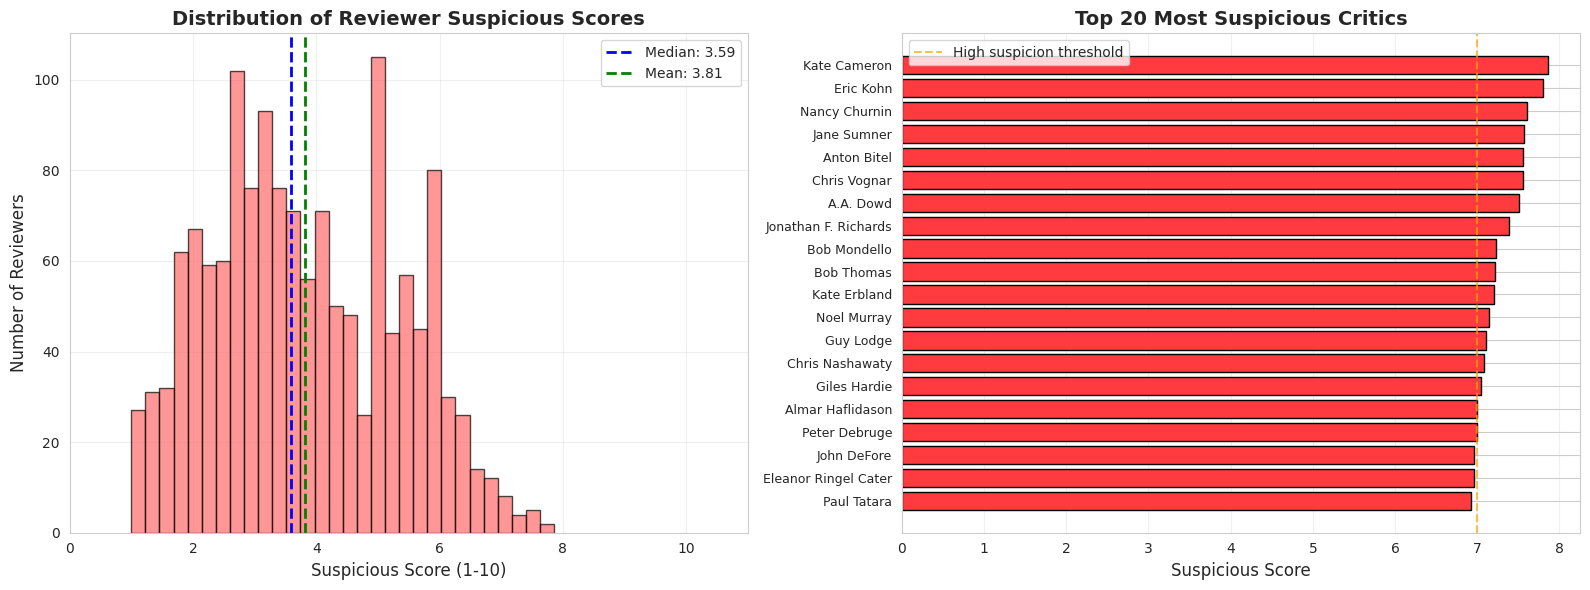

In [96]:
# Histogram + Top 20
print("\nAnaliza wskaźnika podejrzliwości")

print(f"   Łącznie recenzentów: {len(reviewer_stats)}")
print(f"   Wysoko podejrzani (>7): {(reviewer_stats['suspicious_score'] > 7).sum()} ({(reviewer_stats['suspicious_score'] > 7).sum()/len(reviewer_stats)*100:.1f}%)")
print(f"   Średnia: {reviewer_stats['suspicious_score'].mean():.2f}")
print(f"   Mediana: {reviewer_stats['suspicious_score'].median():.2f}")

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram
axes[0].hist(reviewer_stats['suspicious_score'], bins=30, edgecolor='black',
            color='#FF6B6B', alpha=0.7)
axes[0].axvline(reviewer_stats['suspicious_score'].median(),
               color='blue', linestyle='--', linewidth=2,
               label=f"Median: {reviewer_stats['suspicious_score'].median():.2f}")
axes[0].axvline(reviewer_stats['suspicious_score'].mean(),
               color='green', linestyle='--', linewidth=2,
               label=f"Mean: {reviewer_stats['suspicious_score'].mean():.2f}")
axes[0].set_xlabel('Suspicious Score (1-10)', fontsize=12)
axes[0].set_ylabel('Number of Reviewers', fontsize=12)
axes[0].set_title('Distribution of Reviewer Suspicious Scores',
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 11)

# 2. Top 20 bar chart
top_20_suspicious = reviewer_stats.nlargest(20, 'suspicious_score')
axes[1].barh(range(20), top_20_suspicious['suspicious_score'].values,
            color='#FF3B3F', edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_20_suspicious['critic_name'].values, fontsize=9)
axes[1].set_xlabel('Suspicious Score', fontsize=12)
axes[1].set_title('Top 20 Most Suspicious Critics',
                 fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(7, color='orange', linestyle='--', linewidth=1.5,
               alpha=0.7, label='High suspicion threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

#Statystyki podejrzenia dla filmów oraz ich producentów w zależności od ilości podejrzanych recenzentów/recenzji

In [97]:
import numpy as np
import pandas as pd

SUS_TH = 7.0
# alternatywnie: SUS_TH = df['suspicious_score'].quantile(0.995)

df['is_suspicious_reviewer'] = (
    (df['suspicious_score'] >= SUS_TH)
    .fillna(False)
    .astype(int)
)

movie_susp = (
    df.groupby('movie_title')
      .agg(
          suspicious_reviews=('is_suspicious_reviewer', 'sum'),
          total_reviews=('is_suspicious_reviewer', 'size'),
          suspicious_ratio=('is_suspicious_reviewer', 'mean'),
          suspicious_reviewers=('critic_name', lambda s: s[df.loc[s.index, 'is_suspicious_reviewer'].eq(1)].nunique())
      )
      .reset_index()
)

MIN_TOTAL = 10
movie_susp = movie_susp[movie_susp['total_reviews'] >= MIN_TOTAL].copy()

movie_susp = movie_susp.sort_values(
    ['suspicious_reviews', 'suspicious_ratio', 'total_reviews'],
    ascending=[False, False, False]
)

movie_susp.head(20)


,movie_title,suspicious_reviews,total_reviews,suspicious_ratio,suspicious_reviewers
9795,Roma,12,112,0.107143,6
10669,Spectre,10,112,0.089286,5
10789,Star Wars: Episode VII - The Force Awakens,10,128,0.078125,5
10900,Stories We Tell,8,90,0.088889,4
10582,Son of Saul,8,104,0.076923,4
9998,Saving Mr. Banks,8,106,0.075472,4
9232,Precious: Based on the Novel Push by Sapphire,8,108,0.074074,4
9817,Room,8,110,0.072727,4
10605,Sorry to Bother You,8,110,0.072727,4
9497,Ready Player One,8,112,0.071429,4


In [98]:
movie_susp_studio = movie_susp.merge(
    movies_df[['movie_title', 'production_company']].drop_duplicates(),
    on='movie_title',
    how='left'
)

movie_susp_studio.head(20)


,movie_title,suspicious_reviews,total_reviews,suspicious_ratio,suspicious_reviewers,production_company
0,Roma,12,112,0.107143,6,Netflix
1,Spectre,10,112,0.089286,5,Sony Pictures
2,Star Wars: Episode VII - The Force Awakens,10,128,0.078125,5,Walt Disney Pictures
3,Stories We Tell,8,90,0.088889,4,Roadside Attractions
4,Son of Saul,8,104,0.076923,4,Sony Pictures Classics
5,Saving Mr. Banks,8,106,0.075472,4,Walt Disney Pictures
6,Precious: Based on the Novel Push by Sapphire,8,108,0.074074,4,Lionsgate Films
7,Room,8,110,0.072727,4,Element Pictures
8,Sorry to Bother You,8,110,0.072727,4,Annapurna Pictures
9,Ready Player One,8,112,0.071429,4,Warner Bros. Pictures


In [99]:
# suma podejrzanych recenzji per studio
studio_rank = (
    movie_susp_studio
      .groupby('production_company', dropna=False)
      .agg(
          suspicious_reviews=('suspicious_reviews', 'sum'),
          total_reviews=('total_reviews', 'sum'),
          suspicious_ratio=('suspicious_ratio', 'mean'),   # średnia z filmów
          movies=('movie_title', 'nunique')
      )
      .reset_index()
      .sort_values(['suspicious_reviews', 'movies'], ascending=[False, False])
)

studio_rank.head(20)

# Studia najczęściej występujące w TOP-N filmów
TOP_N = 200
topN = movie_susp_studio.head(TOP_N)

studio_topN = (
    topN.groupby('production_company', dropna=False)
        .agg(
            movies_in_topN=('movie_title', 'nunique'),
            suspicious_reviews_in_topN=('suspicious_reviews', 'sum')
        )
        .reset_index()
        .sort_values(['movies_in_topN', 'suspicious_reviews_in_topN'], ascending=[False, False])
)

studio_topN.head(20)


,production_company,movies_in_topN,suspicious_reviews_in_topN
82,Walt Disney Pictures,12,69
66,Sony Pictures,11,57
56,Paramount Pictures,9,43
1,20th Century Fox,9,42
86,Warner Bros. Pictures,8,37
71,The Weinstein Company,6,32
67,Sony Pictures Classics,6,28
77,Universal Pictures,6,28
26,Focus Features,6,25
61,Roadside Attractions,5,24


# MODEL 3 - Wykrywanie fałszywych/opłaconych/podejrzanych recenzji


Przygotowanie modelu opartego na Hybrid Isolation Forest

In [100]:
# Hybrid Isolation Forest - detekcja fałszywych recenzji
print("\nHybrid Isolation Forest - detekcja fałszywych recenzji")

numerical_features = [
    'reviewer_reviews_last_7d', 'reviewer_burst_ratio_7d', 'positive_ratio',
    'critic_std_score_10', 'days_since_release', 'lexical_diversity', 'avg_word_length',
    'word_count', 'score_residual', 'suspicious_score', 'z_score_critic',
    'sentiment_diff', 'consensus_diff', 'publisher_z_score',
    'bias_score'
]


optional_features = [
    'is_reviewer_burst_any',
    'days_active',
    'unique_movies',
    'review_count',
    'sentence_count'
]

use_optional = True

if use_optional:
    available_optional = [f for f in optional_features if f in df.columns]
    all_features = numerical_features + available_optional
    print(f"   Cechy: {len(numerical_features)} podstawowe + {len(available_optional)} opcjonalne = {len(all_features)}")
else:
    all_features = numerical_features
    print(f"   Cechy: {len(all_features)} podstawowe")

# Filtracja danych
required_cols = ['text_cleaned'] + numerical_features
df_model3 = df[df[required_cols].notna().all(axis=1)].copy()

print(f"   Dataset: {len(df_model3):,} recenzji ({len(df_model3)/len(df)*100:.1f}%)")

# Uzupełnienie braków w optional features
if use_optional:
    for col in available_optional:
        if df_model3[col].isna().sum() > 0:
            if df_model3[col].dtype == bool or df_model3[col].nunique() == 2:
                df_model3[col] = df_model3[col].fillna(0).astype(int)
            else:
                df_model3[col] = df_model3[col].fillna(df_model3[col].median())

X_numerical = df_model3[all_features].values

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

print(f"   Przygotowano cechy numeryczne: {X_numerical_scaled.shape}")



Hybrid Isolation Forest - detekcja fałszywych recenzji
   Cechy: 15 podstawowe + 5 opcjonalne = 20
   Dataset: 174,139 recenzji (61.3%)
   Przygotowano cechy numeryczne: (174139, 20)


In [101]:
# Generowanie embeddingów tekstowych (BERT)
print("\n   Generowanie embeddingów BERT (all-MiniLM-L6-v2, 384 dims)...")

model = SentenceTransformer('all-MiniLM-L6-v2')
text_list = df_model3['text_cleaned'].tolist()

text_embeddings = model.encode(
    text_list,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"   Embeddingi: {text_embeddings.shape}")

# Redukcja wymiarowości (UMAP)
print("\n   Redukcja UMAP (384 → 10 dims)...")

reducer = umap.UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_jobs=-1
)

text_embeddings_reduced = reducer.fit_transform(text_embeddings)

print(f"   Po redukcji: {text_embeddings_reduced.shape}")

# Łączenie cech
print("\n   Łączenie cech numerycznych + tekstowych...")

combined_features = np.hstack([
    X_numerical_scaled,
    text_embeddings_reduced
])

print(f"   Finalna macierz: {combined_features.shape}")
print(f"   Skład: {X_numerical_scaled.shape[1]} numeryczne + {text_embeddings_reduced.shape[1]} tekstowe")



   Generowanie embeddingów BERT (all-MiniLM-L6-v2, 384 dims)...


Batches:   0%|          | 0/2721 [00:00<?, ?it/s]

   Embeddingi: (174139, 384)

   Redukcja UMAP (384 → 10 dims)...
   Po redukcji: (174139, 10)

   Łączenie cech numerycznych + tekstowych...
   Finalna macierz: (174139, 30)
   Skład: 20 numeryczne + 10 tekstowe


Trening modelu, predykcja oraz analiza wyników

In [102]:
# Trening Isolation Forest
print("\n   Trening Isolation Forest...")

contamination = 0.05
n_estimators = 200
max_samples = 256

print(f"      Contamination: {contamination*100:.1f}%")
print(f"      Estimators: {n_estimators}")
print(f"      Max samples: {max_samples}")

iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators=n_estimators,
    max_samples=max_samples,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

iso_forest.fit(combined_features)

anomaly_scores = iso_forest.decision_function(combined_features)
min_score = anomaly_scores.min()
max_score = anomaly_scores.max()

print(f"✅ Isolation Forest trained!")
print(f"   Min score: {min_score:.3f}")
print(f"   Max score: {max_score:.3f}")

# Przetwarzanie wyników
df_model3['anomaly_score'] = anomaly_scores
df_model3['is_fake_review'] = (predictions == -1).astype(int)

min_score = anomaly_scores.min()
max_score = anomaly_scores.max()
df_model3['fraud_probability'] = 100 * (1 - (anomaly_scores - min_score) / (max_score - min_score))

fake_count = df_model3['is_fake_review'].sum()
fake_pct = fake_count / len(df_model3) * 100

print(f"\n   Wykryto:")
print(f"      Łącznie recenzji: {len(df_model3):,}")
print(f"      Fałszywe: {fake_count:,} ({fake_pct:.2f}%)")
print(f"      Prawdziwe: {len(df_model3) - fake_count:,} ({100-fake_pct:.2f}%)")



   Trening Isolation Forest...
      Contamination: 5.0%
      Estimators: 200
      Max samples: 256
✅ Isolation Forest trained!
   Min score: -0.135
   Max score: 0.151

   Wykryto:
      Łącznie recenzji: 174,139
      Fałszywe: 8,707 (5.00%)
      Prawdziwe: 165,432 (95.00%)



   Analiza wyników...

   Top 100 najbardziej podejrzanych recenzji:

   1. Prawdopodobieństwo: 100.0%
      Tekst: seeing the film over and over again year after year i find it never grows overfamiliar it plays like...
      Burst 7d: 2456, Positive ratio: 0.62, Dni od premiery: 20855.0

   2. Prawdopodobieństwo: 98.6%
      Tekst: not a moment of the manchurian candidate lacks edge and tension and a cynical spin...
      Burst 7d: 2456, Positive ratio: 0.62, Dni od premiery: 13583.0

   3. Prawdopodobieństwo: 97.7%
      Tekst: all i want for christmas is to never see all i want for christmas again...
      Burst 7d: 2456, Positive ratio: 0.62, Dni od premiery: 2976.0

   4. Prawdopodobieństwo: 97.4%
      Tekst: gag...
      Burst 7d: 1709, Positive ratio: 0.52, Dni od premiery: 1837.0

   5. Prawdopodobieństwo: 96.7%
      Tekst: you cannot know the history of silent film unless you know the face of renee maria falconetti...
      Burst 7d: 2456, Positive ratio: 0.62, Dni od premi

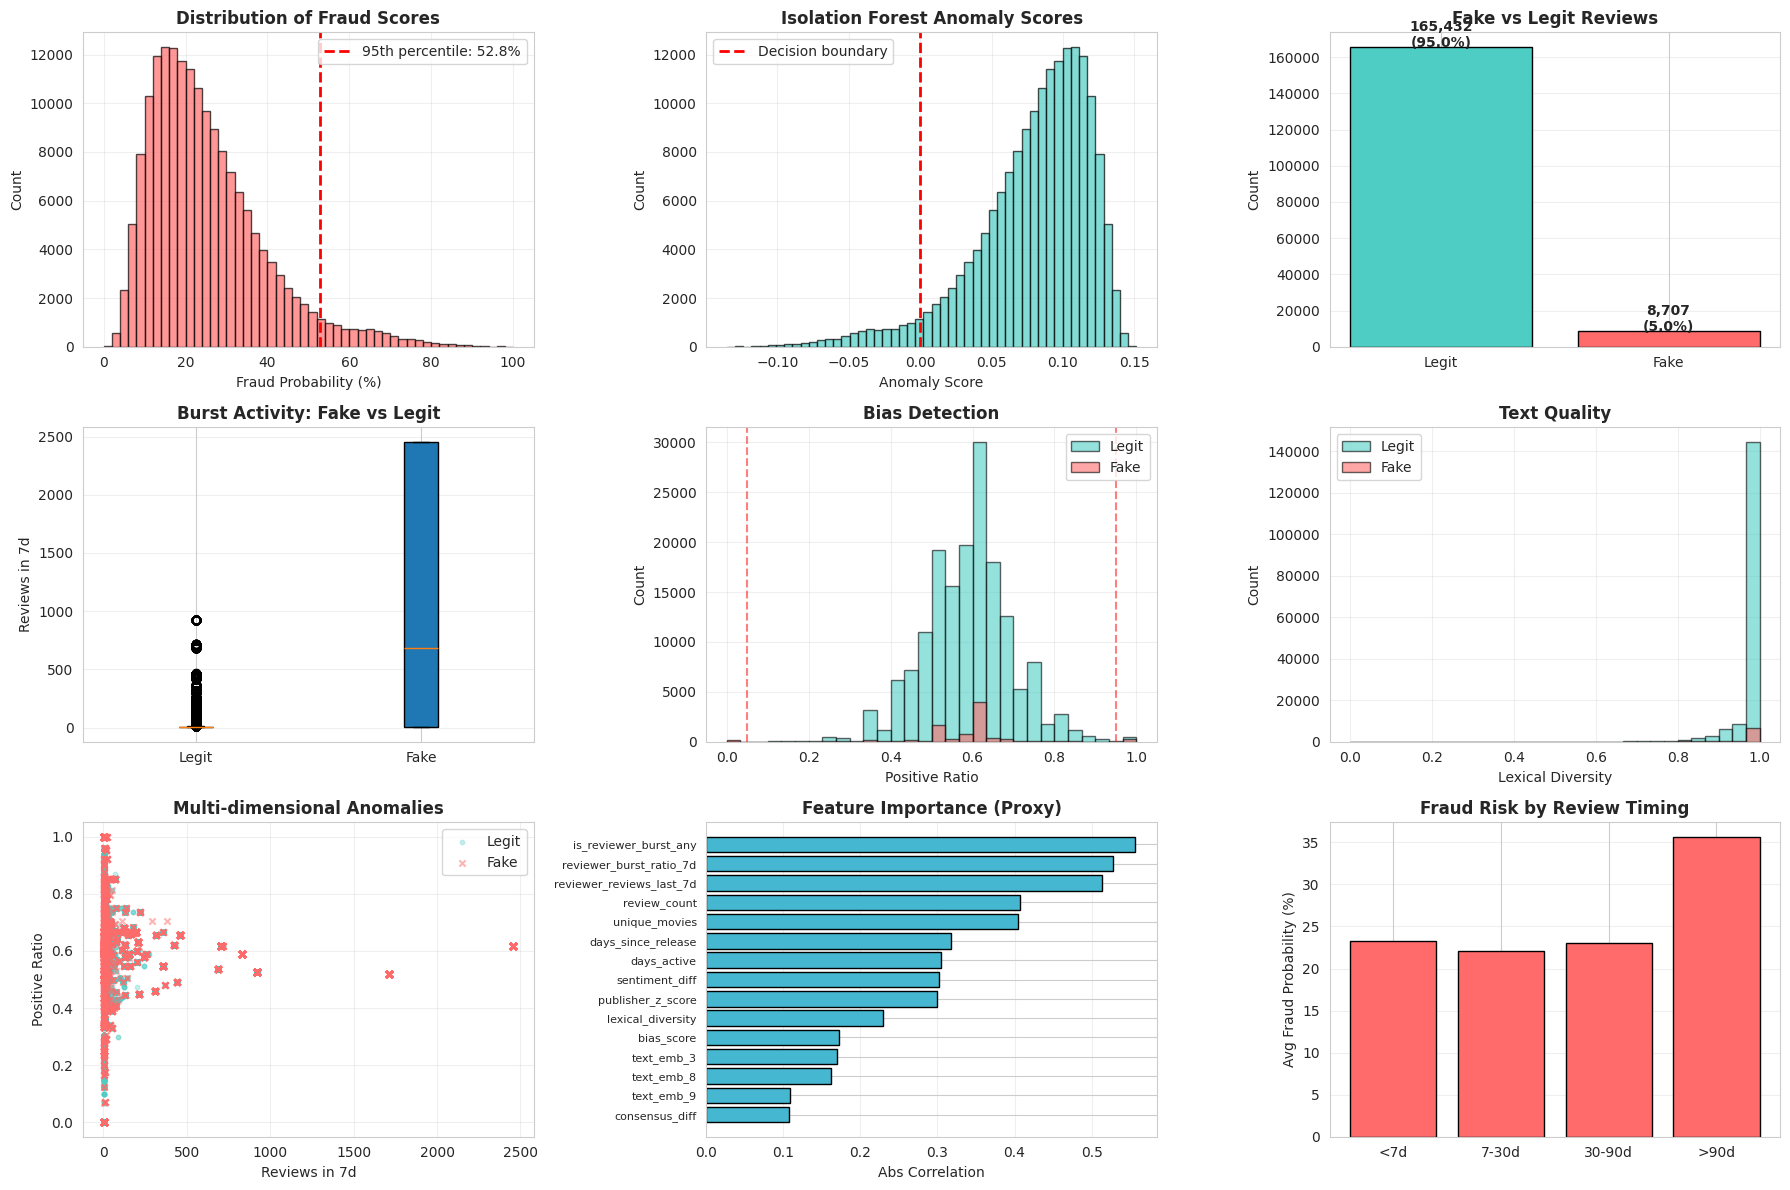


   Zapis wyników...
      Zapisano: model3_all_results.csv
      Zapisano: model3_top_suspicious.csv (top 100)
      Zapisano: model3_summary.txt


In [103]:
# Analiza wyników
print("\n   Analiza wyników...")

top_n = 100
top_suspicious = df_model3.nlargest(top_n, 'fraud_probability')

print(f"\n   Top {top_n} najbardziej podejrzanych recenzji:")

display_cols = ['fraud_probability', 'reviewer_reviews_last_7d', 'positive_ratio',
                'days_since_release', 'lexical_diversity', 'text_cleaned']
available_display = [col for col in display_cols if col in top_suspicious.columns]

for i, (idx, row) in enumerate(top_suspicious.head(10).iterrows(), 1):
    print(f"\n   {i}. Prawdopodobieństwo: {row['fraud_probability']:.1f}%")
    print(f"      Tekst: {row['text_cleaned'][:100]}...")
    print(f"      Burst 7d: {row.get('reviewer_reviews_last_7d', 'N/A')}, "
          f"Positive ratio: {row.get('positive_ratio', 'N/A'):.2f}, "
          f"Dni od premiery: {row.get('days_since_release', 'N/A')}")

# Porównanie fake vs legit
print("\n   Porównanie cech: Fake vs Legit")

fake_df = df_model3[df_model3['is_fake_review'] == 1]
legit_df = df_model3[df_model3['is_fake_review'] == 0]

comparison_features = ['reviewer_reviews_last_7d', 'positive_ratio', 'lexical_diversity',
                       'days_since_release', 'critic_std_score_10']
available_comparison = [f for f in comparison_features if f in df_model3.columns]

print(f"\n   {'Cecha':<30} {'Fake (śr.)':<15} {'Legit (śr.)':<15} {'Różnica':<15}")

for feat in available_comparison:
    fake_mean = fake_df[feat].mean()
    legit_mean = legit_df[feat].mean()
    diff = fake_mean - legit_mean
    print(f"   {feat:<30} {fake_mean:<15.2f} {legit_mean:<15.2f} {diff:<15.2f}")

# Wizualizacje
print("\n   Generowanie wizualizacji...")

fig = plt.figure(figsize=(18, 12))

# 1. Fraud probability distribution
ax1 = plt.subplot(3, 3, 1)
ax1.hist(df_model3['fraud_probability'], bins=50, edgecolor='black', color='#FF6B6B', alpha=0.7)
threshold_95 = df_model3['fraud_probability'].quantile(0.95)
ax1.axvline(threshold_95, color='red', linestyle='--', linewidth=2,
            label=f'95th percentile: {threshold_95:.1f}%')
ax1.set_xlabel('Fraud Probability (%)', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Distribution of Fraud Scores', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Anomaly score distribution
ax2 = plt.subplot(3, 3, 2)
ax2.hist(df_model3['anomaly_score'], bins=50, edgecolor='black', color='#4ECDC4', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Decision boundary')
ax2.set_xlabel('Anomaly Score', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('Isolation Forest Anomaly Scores', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Fake vs Legit count
ax3 = plt.subplot(3, 3, 3)
counts = df_model3['is_fake_review'].value_counts()
colors = ['#4ECDC4', '#FF6B6B']
ax3.bar(['Legit', 'Fake'], [counts.get(0, 0), counts.get(1, 0)], color=colors, edgecolor='black')
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title('Fake vs Legit Reviews', fontsize=12, fontweight='bold')
for i, v in enumerate([counts.get(0, 0), counts.get(1, 0)]):
    ax3.text(i, v + 100, f'{v:,}\n({v/len(df_model3)*100:.1f}%)', ha='center', fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# 4. Feature comparison: reviewer_reviews_last_7d
if 'reviewer_reviews_last_7d' in df_model3.columns:
    ax4 = plt.subplot(3, 3, 4)
    ax4.boxplot([legit_df['reviewer_reviews_last_7d'], fake_df['reviewer_reviews_last_7d']],
                labels=['Legit', 'Fake'], patch_artist=True)
    ax4.set_ylabel('Reviews in 7d', fontsize=10)
    ax4.set_title('Burst Activity: Fake vs Legit', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

# 5. Feature comparison: positive_ratio
if 'positive_ratio' in df_model3.columns:
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(legit_df['positive_ratio'], bins=30, alpha=0.6, label='Legit', color='#4ECDC4', edgecolor='black')
    ax5.hist(fake_df['positive_ratio'], bins=30, alpha=0.6, label='Fake', color='#FF6B6B', edgecolor='black')
    ax5.axvline(0.95, color='red', linestyle='--', alpha=0.5)
    ax5.axvline(0.05, color='red', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Positive Ratio', fontsize=10)
    ax5.set_ylabel('Count', fontsize=10)
    ax5.set_title('Bias Detection', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3)

# 6. Feature comparison: lexical_diversity
if 'lexical_diversity' in df_model3.columns:
    ax6 = plt.subplot(3, 3, 6)
    ax6.hist(legit_df['lexical_diversity'], bins=30, alpha=0.6, label='Legit', color='#4ECDC4', edgecolor='black')
    ax6.hist(fake_df['lexical_diversity'], bins=30, alpha=0.6, label='Fake', color='#FF6B6B', edgecolor='black')
    ax6.set_xlabel('Lexical Diversity', fontsize=10)
    ax6.set_ylabel('Count', fontsize=10)
    ax6.set_title('Text Quality', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)

# 7. Scatter: burst vs positive_ratio
if 'reviewer_reviews_last_7d' in df_model3.columns and 'positive_ratio' in df_model3.columns:
    ax7 = plt.subplot(3, 3, 7)
    ax7.scatter(legit_df['reviewer_reviews_last_7d'], legit_df['positive_ratio'],
                alpha=0.3, s=10, color='#4ECDC4', label='Legit')
    ax7.scatter(fake_df['reviewer_reviews_last_7d'], fake_df['positive_ratio'],
                alpha=0.5, s=20, color='#FF6B6B', marker='x', label='Fake')
    ax7.set_xlabel('Reviews in 7d', fontsize=10)
    ax7.set_ylabel('Positive Ratio', fontsize=10)
    ax7.set_title('Multi-dimensional Anomalies', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(alpha=0.3)

# 8. Feature importance
ax8 = plt.subplot(3, 3, 8)
feature_names = all_features + [f'text_emb_{i}' for i in range(10)]
feature_matrix = pd.DataFrame(combined_features, columns=feature_names)
feature_matrix['anomaly_score'] = anomaly_scores
correlations = feature_matrix.corr()['anomaly_score'].drop('anomaly_score').abs().sort_values(ascending=False)
top_corr = correlations.head(15)
ax8.barh(range(len(top_corr)), top_corr.values, color='#45B7D1', edgecolor='black')
ax8.set_yticks(range(len(top_corr)))
ax8.set_yticklabels(top_corr.index, fontsize=8)
ax8.set_xlabel('Abs Correlation', fontsize=10)
ax8.set_title('Feature Importance (Proxy)', fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(alpha=0.3, axis='x')

# 9. Fraud probability by days_since_release
if 'days_since_release' in df_model3.columns:
    ax9 = plt.subplot(3, 3, 9)
    bins = [-np.inf, 7, 30, 90, np.inf]
    labels = ['<7d', '7-30d', '30-90d', '>90d']
    df_model3['release_bin'] = pd.cut(df_model3['days_since_release'], bins=bins, labels=labels)
    fraud_by_timing = df_model3.groupby('release_bin')['fraud_probability'].mean()
    ax9.bar(range(len(fraud_by_timing)), fraud_by_timing.values, color='#FF6B6B', edgecolor='black')
    ax9.set_xticks(range(len(fraud_by_timing)))
    ax9.set_xticklabels(fraud_by_timing.index)
    ax9.set_ylabel('Avg Fraud Probability (%)', fontsize=10)
    ax9.set_title('Fraud Risk by Review Timing', fontsize=12, fontweight='bold')
    ax9.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model3_fake_review_detection_analysis.png', dpi=150, bbox_inches='tight')
print("      Zapisano: model3_fake_review_detection_analysis.png")
plt.show()

# Zapis wyników
print("\n   Zapis wyników...")

output_cols = [
    'fraud_probability', 'is_fake_review', 'anomaly_score',
    'text_cleaned', 'review_content',
    'reviewer_reviews_last_7d', 'positive_ratio', 'days_since_release',
    'lexical_diversity', 'critic_std_score_10', 'suspicious_score',
    'movie_title', 'critic_name', 'review_date'
]

output_cols_available = [col for col in output_cols if col in df_model3.columns]

df_model3[output_cols_available].to_csv('model3_all_results.csv', index=False, encoding='utf-8')
print("      Zapisano: model3_all_results.csv")

top_suspicious[output_cols_available].to_csv('model3_top_suspicious.csv', index=False, encoding='utf-8')
print(f"      Zapisano: model3_top_suspicious.csv (top {top_n})")

with open('model3_summary.txt', 'w', encoding='utf-8') as f:
    f.write("MODEL 3: HYBRID ISOLATION FOREST - PODSUMOWANIE\n\n")
    f.write(f"Łącznie recenzji: {len(df_model3):,}\n")
    f.write(f"Oznaczone jako fake: {fake_count:,} ({fake_pct:.2f}%)\n")
    f.write(f"Contamination threshold: {contamination*100}%\n\n")
    f.write("Konfiguracja cech:\n")
    f.write(f"  Cechy numeryczne: {len(all_features)}\n")
    f.write(f"  Text embedding dims: 10 (UMAP z 384)\n")
    f.write(f"  Łączne wymiary: {combined_features.shape[1]}\n\n")
    f.write("Top cechy wg korelacji z anomaly score:\n")
    for i, (feat, corr) in enumerate(correlations.head(10).items(), 1):
        f.write(f"  {i}. {feat}: {corr:.3f}\n")

print("      Zapisano: model3_summary.txt")


#WIP - GUI

In [121]:
# ========================================
# GUI - POPRAWIONA FUNKCJA (20 FEATURES!)
# ========================================

def prepare_single_review_features(review_text):
    """
    Przygotowuje cechy - POPRAWIONE NA 20 NUMERICAL FEATURES
    """
    print("\n" + "="*60)
    print("🔍 PREPARING FEATURES")
    print("="*60)

    try:
        # 1. Czyszczenie
        cleaned = review_text.strip()
        cleaned = re.sub(r'<[^>]+>', '', cleaned)
        cleaned = re.sub(r'http\S+|www\.\S+', '', cleaned)
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()

        print(f"✅ Cleaned: {len(cleaned)} chars")

        if len(cleaned) < 5:
            return None, None

        # 2. Embedding
        embedding = model.encode([cleaned])[0]
        embedding_reduced = reducer.transform(embedding.reshape(1, -1))
        print(f"✅ Embedding: {embedding_reduced.shape}")

        # 3. Numerical features
        words = cleaned.lower().split()
        unique_words = set(words)

        word_count = len(words)
        sentence_count = cleaned.count('.') + cleaned.count('!') + cleaned.count('?') + 1
        lexical_div = len(unique_words) / word_count if word_count > 0 else 0
        avg_word_length = sum(len(w) for w in words) / word_count if word_count > 0 else 0

        positive_words = {'good', 'great', 'excellent', 'amazing', 'wonderful',
                         'best', 'love', 'brilliant', 'fantastic', 'perfect',
                         'masterpiece', 'stunning', 'superb', 'outstanding'}
        positive_ratio = sum(1 for w in words if w in positive_words) / word_count if word_count > 0 else 0

        predicted_sentiment = 1

        # 4. Create 20 numerical features (15 podstawowych + 5 opcjonalnych)
        numerical_features = np.array([
            0,  # 0: reviewer_reviews_last_7d
            0,  # 1: reviewer_burst_ratio_7d
            positive_ratio,  # 2: positive_ratio
            0,  # 3: critic_std_score10
            0,  # 4: days_since_release
            lexical_div,  # 5: lexical_diversity
            avg_word_length,  # 6: avg_word_length
            word_count,  # 7: wordcount
            0,  # 8: score_residual
            0,  # 9: suspicious_score
            0,  # 10: zscore_critic
            0,  # 11: sentiment_diff
            0,  # 12: consensus_diff
            0,  # 13: publisher_zscore
            0,  # 14: bias_score
            # OPTIONAL FEATURES (5 dodatkowych):
            0,  # 15: is_reviewer_burst_any
            0,  # 16: days_active
            0,  # 17: unique_movies
            0,  # 18: review_count
            sentence_count  # 19: sentence_count
        ]).reshape(1, -1)

        print(f"✅ Numerical features: {numerical_features.shape} (expected: 20)")

        # 5. Scale
        numerical_scaled = scaler.transform(numerical_features)

        # 6. Combine: [20 numerical] + [10 embedding] = 30 total
        combined = np.hstack([numerical_scaled, embedding_reduced])
        print(f"✅ Combined: {combined.shape}")

        feature_info = {
            'lexical_div': lexical_div,
            'positive_ratio': positive_ratio,
            'word_count': word_count,
            'sentiment': predicted_sentiment,
            'avg_word_length': avg_word_length,
            'cleaned_text': cleaned[:200]
        }

        print("✅ SUCCESS!")
        print("="*60 + "\n")

        return combined, feature_info

    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
        return None, None

print("✅ Function loaded with 20 features!")


✅ Function loaded with 20 features!


In [122]:
# ========================================
# GUI - FUNKCJA DETEKCJI
# ========================================

def detect_fake_review(review_text, threshold=0.5):
    """
    Główna funkcja predykcji - wykrywa fake reviews używając Isolation Forest

    Args:
        review_text (str): Tekst recenzji
        threshold (float): Próg decyzyjny (0-1), domyślnie 0.5

    Returns:
        verdict (str): Werdykt (Fake/Legit)
        probability (str): Prawdopodobieństwo fake (%)
        details (str): Szczegóły analizy
    """
    if not review_text or not review_text.strip():
        return "⚠️ No Input", "N/A", "Please enter a review to analyze"

    try:
        # Przygotuj cechy
        features, feature_info = prepare_single_review_features(review_text)

        if features is None:
            return "⚠️ Error", "N/A", "Could not process text (too short or invalid)"

        # ===== PREDYKCJA ISOLATION FOREST =====
        anomaly_score = iso_forest.decision_function(features)[0]

        # Normalizuj do prawdopodobieństwa 0-1
        fraud_probability = 1 - (anomaly_score - min_score) / (max_score - min_score)
        fraud_probability = np.clip(fraud_probability, 0, 1)

        # Werdykt
        is_fake = fraud_probability > threshold
        verdict = "🚨 FAKE/BIASED" if is_fake else "✅ LEGIT"

        # Szczegóły
        sentiment_label = "😊 Positive" if feature_info['sentiment'] == 1 else "😞 Negative"

        details = f"""
**📊 Fraud Detection Analysis**

🎯 **Fraud Probability: {fraud_probability:.1%}**
📏 Anomaly Score: {anomaly_score:.3f}
⚖️ Threshold: {threshold:.1%}

---

**📝 Text Quality Features:**
• Word Count: {feature_info['word_count']} words
• Lexical Diversity: {feature_info['lexical_div']:.3f} (unique words / total)
• Positive Word Ratio: {feature_info['positive_ratio']:.3f}
• Avg Word Length: {feature_info['avg_word_length']:.2f} chars
• Sentiment: {sentiment_label}

---

**🔍 Cleaned Text (preview):**
"{feature_info['cleaned_text']}..."

---

**ℹ️ Interpretation:**
{'⚠️ This review shows suspicious patterns typical of fake/biased reviews.' if is_fake else '✅ This review appears to be legitimate based on text patterns.'}
        """.strip()

        return verdict, f"{fraud_probability:.1%}", details

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        return "⚠️ ERROR", "N/A", f"**Error occurred:**\n```\n{str(e)}\n```\n\n**Traceback:**\n```\n{error_details}\n```"

print("✅ Function detect_fake_review() loaded")


✅ Function detect_fake_review() loaded


In [123]:
# ========================================
# GRADIO GUI - Z DŁUŻSZYMI PRZYKŁADAMI
# ========================================

import gradio as gr

print("\n" + "="*70)
print("🚀 Launching Fake Review Detection GUI...")
print("="*70)

# Sprawdź czy wszystkie zmienne są dostępne
print("\n✅ Checking required variables:")
required_vars = ['model', 'reducer', 'scaler', 'iso_forest', 'min_score', 'max_score']
for var in required_vars:
    try:
        val = eval(var)
        print(f"   ✓ {var}: {type(val).__name__}")
    except NameError:
        print(f"   ✗ {var}: NOT FOUND!")

with gr.Blocks(theme=gr.themes.Soft(), title="Fake Review Detector") as demo:
    gr.Markdown("""
    # 🔍 Rotten Tomatoes Fake Review Detector

    ### 🤖 Model Stack:
    - **Model 1**: Sentiment Analysis (Logistic Regression)
    - **Model 2**: Score Prediction (Ridge Regression)
    - **Model 3**: Fake Detection (Isolation Forest) ← **🎯 Current**

    This tool analyzes movie reviews to detect potentially fake or biased content using:
    - 📊 Text embeddings (SentenceTransformer)
    - 📈 Lexical diversity & writing quality
    - 🎭 Sentiment analysis
    - 🔬 Anomaly detection (Isolation Forest)
    """)

    with gr.Row():
        with gr.Column(scale=2):
            text_input = gr.Textbox(
                label="📝 Enter Movie Review",
                lines=10,
                placeholder="Paste or type any movie review here...\n\nExample: 'This movie is absolutely amazing! The cinematography was stunning and the performances were incredible. A true masterpiece!'",
                info="The model will analyze text patterns to detect suspicious reviews"
            )

            with gr.Row():
                threshold_slider = gr.Slider(
                    0, 1,
                    value=0.5,
                    step=0.05,
                    label="🎚️ Detection Sensitivity",
                    info="Higher = more strict (more reviews flagged as fake). Recommended: 0.5"
                )

            with gr.Row():
                clear_btn = gr.ClearButton([text_input], value="🗑️ Clear", size="sm")
                submit_btn = gr.Button("🔍 Analyze Review", variant="primary", size="lg")

        with gr.Column(scale=1):
            output_verdict = gr.Textbox(
                label="📊 Verdict",
                interactive=False,
                lines=1
            )
            output_prob = gr.Textbox(
                label="🎯 Fraud Probability",
                interactive=False,
                lines=1
            )
            output_details = gr.Textbox(
                label="📈 Detailed Analysis",
                lines=18,
                interactive=False,
                show_copy_button=True
            )

    # Przykłady - DŁUŻSZE RECENZJE
    gr.Markdown("### 💡 Example Reviews (Click to Test)")

    gr.Examples(
        examples=[
            # 1. SUSPICIOUS - Fake negative (repetitive, extreme)
            ["""This movie is absolutely terrible! The worst film I have ever seen in my entire life! Complete garbage from start to finish! Don't waste your time or money on this horrible disaster! The acting was terrible, the plot was terrible, the directing was terrible, everything was just absolutely terrible! Zero stars! Awful! Horrible! Disgusting! I want my money back! Worst movie ever made! Stay away from this trash!"""],

            # 2. LEGIT - Balanced critical review
            ["""A thoughtful and nuanced exploration of complex themes that doesn't always hit its mark, but remains compelling throughout. The film is elevated by strong performances from the lead actors, particularly in the emotional third act. While the pacing occasionally drags in the middle section, the careful direction and beautiful cinematography help maintain interest. The screenplay offers some genuinely insightful moments, though it sometimes struggles to balance its multiple narrative threads. Overall, a flawed but worthwhile entry in the genre that demonstrates clear artistic ambition."""],

            # 3. SUSPICIOUS - Fake positive (repetitive, excessive)
            ["""AMAZING AMAZING AMAZING!!! This is the BEST movie I have EVER seen! PERFECT in every way! The acting is PERFECT! The story is PERFECT! The cinematography is PERFECT! Everything is just PERFECT PERFECT PERFECT! Everyone MUST watch this MASTERPIECE right now! 10/10! Best film ever made! Absolutely wonderful spectacular magnificent brilliant fantastic outstanding superb! You will LOVE LOVE LOVE this movie! Don't miss this incredible amazing wonderful masterpiece!!!"""],

            # 4. LEGIT - Positive but measured
            ["""An impressive achievement that manages to balance spectacle with substance. The director demonstrates a clear understanding of the source material while bringing fresh perspective to familiar themes. The ensemble cast delivers uniformly strong performances, with the supporting actors providing surprising depth to what could have been one-dimensional roles. The visual effects serve the story rather than overwhelming it, and the score effectively enhances the emotional resonance. While not without minor flaws - some dialogue feels heavy-handed and the runtime could be trimmed - this is ultimately a satisfying and well-crafted film that respects its audience."""],

            # 5. SUSPICIOUS - Low diversity, repetitive words
            ["""great great great movie very great film great acting great story great director great cinematography great everything so great wonderful great spectacular great best great perfect great amazing great fantastic great brilliant great outstanding great superb great excellent great magnificent great"""],

            # 6. LEGIT - Critical but constructive
            ["""The film opens with promise, establishing an intriguing premise and introducing well-drawn characters. However, as the narrative progresses, it becomes clear that the screenplay lacks the depth needed to fully explore its ambitious themes. The cinematography beautifully captures the melancholic tone, and the lead performance brings genuine emotional weight to the material. Unfortunately, the pacing issues in the second act and an underdeveloped subplot detract from the overall impact. While the technical craft is evident and there are moments of genuine brilliance, the film ultimately struggles to maintain the momentum of its strong beginning."""],

            # 7. LEGIT - Mixed review with specific details
            ["""While the film succeeds in creating a visually striking world and features several standout performances, it falters in its execution of the central relationship. The first half moves at a brisk pace, efficiently establishing the stakes and character motivations. However, the narrative loses focus in the latter portion, relying too heavily on convenient plot devices rather than organic character development. The production design deserves praise for its attention to period detail, and the costume work effectively reinforces character arcs without being overly obvious. Despite these strengths, the uneven tone and rushed conclusion prevent this from reaching its full potential."""],

            # 8. SUSPICIOUS - Extreme negative, no substance
            ["""Absolute trash! Worst thing ever! Garbage! Terrible! Horrible! Awful! Bad! Poor! Disappointing! Waste of time! Waste of money! Don't watch! Save yourself! Boring! Stupid! Dumb! Pointless! Useless! Disaster! Failure! Mess! Joke! Embarrassing! Shameful! Disgusting! Revolting!"""]
        ],
        inputs=text_input,
        label="Click any example to test (includes both suspicious and legitimate reviews):",
        examples_per_page=8
    )

    # Footer
    gr.Markdown("""
    ---
    **📌 How it works:**
    - Analyzes writing patterns, lexical diversity, sentiment, and text quality
    - Trained on real Rotten Tomatoes reviews using Isolation Forest
    - **High fraud probability** = suspicious patterns (repetitive, extreme sentiment, low diversity)
    - **Low fraud probability** = natural writing patterns, balanced tone, specific details

    **🎯 What makes a review suspicious?**
    - Excessive repetition of the same words
    - Extreme sentiment with no nuance or specific details
    - Very low lexical diversity (few unique words)
    - Unnaturally positive or negative without substance

    **⚠️ Note:** Statistical model - use as detection aid, not definitive proof.
    """)

    # Event handlers
    submit_btn.click(
        fn=detect_fake_review,
        inputs=[text_input, threshold_slider],
        outputs=[output_verdict, output_prob, output_details]
    )

# Launch
print("\n✅ GUI ready! Launching...\n")

demo.launch(
    share=True,  # Tworzy publiczny link (72h)
    show_error=True
)



🚀 Launching Fake Review Detection GUI...

✅ Checking required variables:
   ✓ model: SentenceTransformer
   ✓ reducer: UMAP
   ✓ scaler: StandardScaler
   ✓ iso_forest: IsolationForest
   ✓ min_score: float64
   ✓ max_score: float64

✅ GUI ready! Launching...

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fa4a0c373f41eca5f2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
